# Datasets gemeenteraadsverkiezingen 2022
Deze notebook heeft als doel de stemlokalen van de gemeenteraadsverkiezingen van 2022 te analyseren. Er zal hier stap voor stap door de data gelopen worden om het proces reproduceerbaar te maken voor latere verkiezingen. De eerste stap was de data ophalen van de bronnen, zowel van de overheid als van 'Waar is mijn stemlokaal' (voor geografische data van de stemlokalen). Deze bronnen zijn voor de verkiezingen van 2022 gebruikt:
- [Verkiezingsuitslagen Gemeenteraad 2022](https://data.overheid.nl/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43)
  - [Directe link naar uitslagen per gemeente EML](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_2022-03-29T15.14.zip)
  - [Directe link naar kandidatenlijst met uitslagen CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_alle-kandidaten_2022-02-22T08.34.csv)
- ['Waar is mijn stemlokaal' stembureau data](https://waarismijnstemlokaal.nl/data)
  - [Directe link naar 'Waar is mijn stemlokaal' gemeenteraad 2022 CSV (CKAN)](https://ckan.dataplatform.nl/datastore/dump/d6a1b4c4-73c8-457b-9b75-a38428bded68)
  - [Verkiezingsuitslagen gemeenteraadsverkiezingen 2022 geodata vab Open State Foundation en de Volkskrant (OSF/VK)](https://data.openstate.eu/dataset/verkiezingsuitslagen-gemeenteraadsverkiezingen-2022)
    - [Directe link naar GeoJSON bestand](https://data.openstate.eu/dataset/a1767f1b-bf0c-409b-b3b1-3af9954b57f4/resource/413be255-5070-48f4-b631-895097976abb/download/2022gr.geo.json)
- [CBS Wijk- en buurtkaart 2021](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021)
  - [Directe link naar zip bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip)
- [CBS bevolkingsdichtheid kaart 100 bij 100 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/100/nl_vierkant_100meter_bij_100meter.7z)
- [CBS bevolkingsdichtheid kaart 500 bij 500 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-500-meter-bij-500-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/500/2021-cbs_vk500_2020_v1.zip)
- [CBS schatting van kiesgerechtigden per gemeente](https://www.cbs.nl/nl-nl/maatwerk/2020/52/schatting-van-het-aantal-kiesgerechtigden-in-nederland)

# Data inladen en eerste analyse
## OSF/VK GeoJSON dataset: verkiezingsuitslagen per stembureau inclusief coördinaten
Als eerste importeren we de data voor de analyse, daarna kunnen we kijken hoe goed de data is, hoe we het aan kunnen vullen, en wat er mee te doen. We kijken eerst naar het GeoJSON bestand van Open State Foundation en de Volkskrant (OSF/VK). Daarin zijn de coördinaten van alle locaties van bijna alle stembureaus toegevoegd aan de lijst met stembureaus uit de officiële uitslagen zoals gepubliceerd door de Kiesraad. We kunnen een GeoJSON bestand direct inladen met geopandas.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import geopandas as gpd

crs = {'init':'EPSG:4326'}
df_geojson = gpd.read_file(r'../data/2022gr.geo.json', crs=crs)

## CBS dataset: gemeentegrenzen en informatie
We importeren nu de gemeente shapefile kaart van het CBS, om de overlay van onze stemlokalen eroverheen te leggen.

<AxesSubplot:title={'center':'Plot van de gemeenten uit de CBS Wijk- en buurtkaart 2021'}>

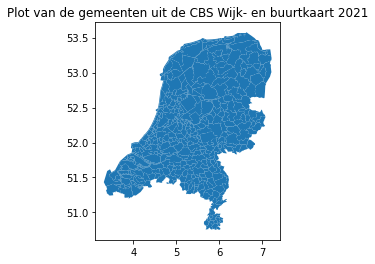

In [3]:
nl_map = gpd.read_file(r'../data/shape/Netherlands_shapefile/gemeente_2021_v1.shp')
plot = nl_map.to_crs(epsg=4326).plot()
plot.set_title('Plot van de gemeenten uit de CBS Wijk- en buurtkaart 2021')
plot


De CBS Wijk- en buurtkaart 2021 bevat ook naast de gemeentegrenzen ook informatie (bv. aantal inwoners) over de gemeenten. We printen dat hier uit om daar een beeld van te krijgen.

In [4]:
print(nl_map)

    GM_CODE            GM_NAAM  H2O       OAD      STED  BEV_DICHTH  AANT_INW  \
0    GM0034             Almere   JA -99999999 -99999999   -99999999 -99999999   
1    GM0050           Zeewolde   JA -99999999 -99999999   -99999999 -99999999   
2    GM0060            Ameland   JA -99999999 -99999999   -99999999 -99999999   
3    GM0072          Harlingen   JA -99999999 -99999999   -99999999 -99999999   
4    GM0088    Schiermonnikoog   JA -99999999 -99999999   -99999999 -99999999   
..      ...                ...  ...       ...       ...         ...       ...   
430  GM1966       Het Hogeland  NEE       414         5          99     47834   
431  GM1969     Westerkwartier  NEE       476         5         176     63678   
432  GM1970  Noardeast-Fryslân  NEE       463         5         120     45481   
433  GM1978        Molenlanden  NEE       393         5         243     44130   
434  GM1979          Eemsdelta  NEE       692         4         170     45587   

     AANT_MAN  AANT_VROUW  

Hieronder plotten we de gegevens van stembureaus op de kaart van het CBS:

Text(0.5, 1.0, 'Stembureaus op de gemeentekaart van het CBS')

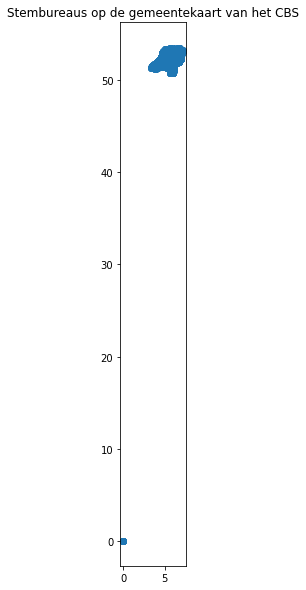

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson.plot(ax=ax)
ax.set_title('Stembureaus op de gemeentekaart van het CBS')

We hebben hier een probleem dat sommige punten de coördinaten 0,0 hebben, dit is niet iets wat we willen weergeven. Laten we eerst kijken waarom dit het geval is in de data voordat we het er helemaal uithalen.

In [6]:
for index, row in df_geojson.iterrows():
    if (row.geometry.centroid.x == 0.00000):
        print(row)

Stembureau                                     32
Adres                                            
Locatie                                      SB32
description        Stembureau Mobiel Stembureau 1
Geldige stemmen                                99
                                ...              
één-Ermelo                                    NaN
gmcode                                     GM0109
election                         GR2022_Coevorden
electionName          Gemeenteraad Coevorden 2022
geometry                              POINT (0 0)
Name: 2520, Length: 973, dtype: object
Stembureau                                     33
Adres                                            
Locatie                                      SB33
description        Stembureau Mobiel Stembureau 2
Geldige stemmen                               115
                                ...              
één-Ermelo                                    NaN
gmcode                                     GM0109
election   

Het zijn dus duidelijk allemaal mobiele stemlokalen, die kunnen we in een aparte dataset houden voor later, voor nu zijn ze onbelangrijk voor de kaartweergave, laten we de dataset dus opsplitsen in drie dataframes, de originele, één frame zonder de mobiele stemlokalen, en de mobiele stemlokalen alleen.

In [7]:
# De waarschuwing over de projectie die niet klopt kan genegeerd worden, we zoeken naar data die x = 0 is,
# de projectie gaat geen effect hebben op die data in Nederland.

# Filter de data en print welke waardes 0 hebben op x.
mobiel_mask = df_geojson['geometry'].centroid.x == 0
i = 0
for item in mobiel_mask:
    if item:
        print(i)
    i = i + 1

2520
2521
2918
3579
3580
3581
3582
3583
5494
5784
5785
6260
6261
6738
6739
6863
7348
7364
7857
7912
7913
7923
7924
7926
7958
7959
7960
8108
8109
8161
8162
8163
8318
9093
9151
9152
9153
9661
9853
10427
10431
10497
10498
10525
10526
10527
10528
10623
10624
10894
10895
11032
11101
12038
12039
12053
12054
12118
12119
12120
12121
12504
12505
12506


In [8]:
df_geojson_clean = df_geojson[~mobiel_mask]
df_geojson_mobiel = df_geojson[mobiel_mask]
print(df_geojson_clean)

       Stembureau   Adres Locatie  \
0               1  9461BH     SB1   
1               2  9461DA     SB2   
2               3  9461JA     SB3   
3               4  9451KD     SB4   
4               6  9454PL     SB6   
...           ...     ...     ...   
12591         703  5391AR   SB703   
12592         705  5391AR   SB705   
12593         750  5382KE   SB750   
12594         751  5382KE   SB751   
12595         752  5283KE   SB752   

                                             description  Geldige stemmen  \
0      Stembureau Gemeentehuis Gieten (postcode: 9461...              784   
1              Stembureau OBS Gieten (postcode: 9461 DA)              562   
2      Stembureau Zorgcentrum Dekelhem (postcode: 946...              566   
3      Stembureau Ontmoetingscentrum Boerhorn Rolde (...             1495   
4      Stembureau Dropshuis de Eekhof (postcode: 9454...              347   
...                                                  ...              ...   
12591  Stemburea

In [9]:
# Let's also check if none fell through the cracks, it might be some mobile polls did actually have a location
# posted erroneously
#mobiel_mask_name = df_geojson_clean['description'].str.contains('Mobiel')
#df_geojson_clean = df_geojson_clean[~mobiel_mask_name]
#df_geojson_clean

## 'Waar is mijn stemlokaal' dataset (wims)

In [10]:
df_wims = pd.read_csv(r'../data/wims_clean.csv')
df_wims

,Unnamed: 0,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,...,Visuele hulpmiddelen,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID
0,0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,...,leesloep,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258
1,1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba
2,2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c
3,3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0
4,4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee
9271,9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408
9272,9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c
9273,9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083


In [11]:
df_wims2 = pd.read_csv(r'../data/wims-3.csv')
df_wims['Gebruiksdoel van het gebouw'] = df_wims['Gebruiksdoel van het gebouw'].mask(df_wims['Gebruiksdoel van het gebouw'].eq(0)).fillna(
    df_wims['UUID'].map(df_wims2.set_index('UUID')['Gebruiksdoel van het gebouw'])
)



In [12]:
df_wims.to_csv(path_or_buf='../data/export/wims_clean.csv', sep=',', na_rep='', header=True)

In [13]:
# Convert the wims data to a geopandas dataframe
gdf_wims = gpd.GeoDataFrame(
    df_wims,
    geometry=gpd.points_from_xy(df_wims.Longitude, df_wims.Latitude)
).set_crs(epsg=4326, inplace=True)

gdf_wims

,Unnamed: 0,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,geometry
0,0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,...,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258,POINT (5.45515 51.34711)
1,1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba,POINT (5.45137 51.34955)
2,2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c,POINT (5.44827 51.35702)
3,3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0,POINT (5.44871 51.36022)
4,4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d,POINT (5.45331 51.36514)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee,POINT (5.98266 51.69726)
9271,9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408,POINT (5.98127 51.69000)
9272,9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c,POINT (5.95118 51.72591)
9273,9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083,POINT (6.01556 51.70976)


In [14]:
# We only want to analyse stemlokalen so deduplicate the stembureaus based on their location's coordinates
gdf_wims_dedupe = gdf_wims.drop_duplicates(subset="geometry", keep=False)
df_geojson_dedupe = df_geojson_clean.drop_duplicates(subset="geometry", keep=False)
gdf_wims_dedupe

,Unnamed: 0,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,geometry
0,0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,...,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258,POINT (5.45515 51.34711)
1,1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba,POINT (5.45137 51.34955)
2,2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c,POINT (5.44827 51.35702)
3,3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0,POINT (5.44871 51.36022)
4,4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d,POINT (5.45331 51.36514)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee,POINT (5.98266 51.69726)
9271,9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408,POINT (5.98127 51.69000)
9272,9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c,POINT (5.95118 51.72591)
9273,9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083,POINT (6.01556 51.70976)


Voor dit onderzoek zijn we enkel geïnteresseerd in de locaties van stembureaus, oftewel de stemlokalen. Hierboven hebben we de stembureaus uit de wims dataset gededupliceerd op basis van de coördinaten van hun locatie.

Het aantal stembureaus: 9275

Het aantal stemlokalen: 8089

Er zijn dus 1186 stembureaus gevestigd op een locatie van minimaal één ander stembureau.

## Plots van alle stemlokalen op de kaart
### Stemlokalen uit de wims dataset

<AxesSubplot:>

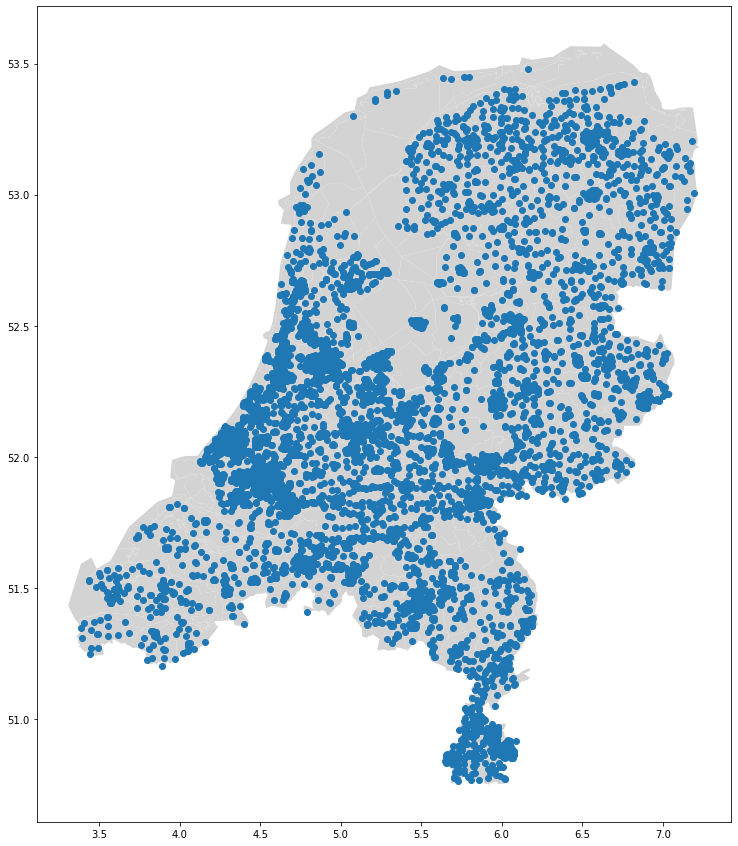

In [15]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
gdf_wims_dedupe.plot(ax=ax)

### Stemlokalen uit de OSF/VK GeoJSON dataset

<AxesSubplot:>

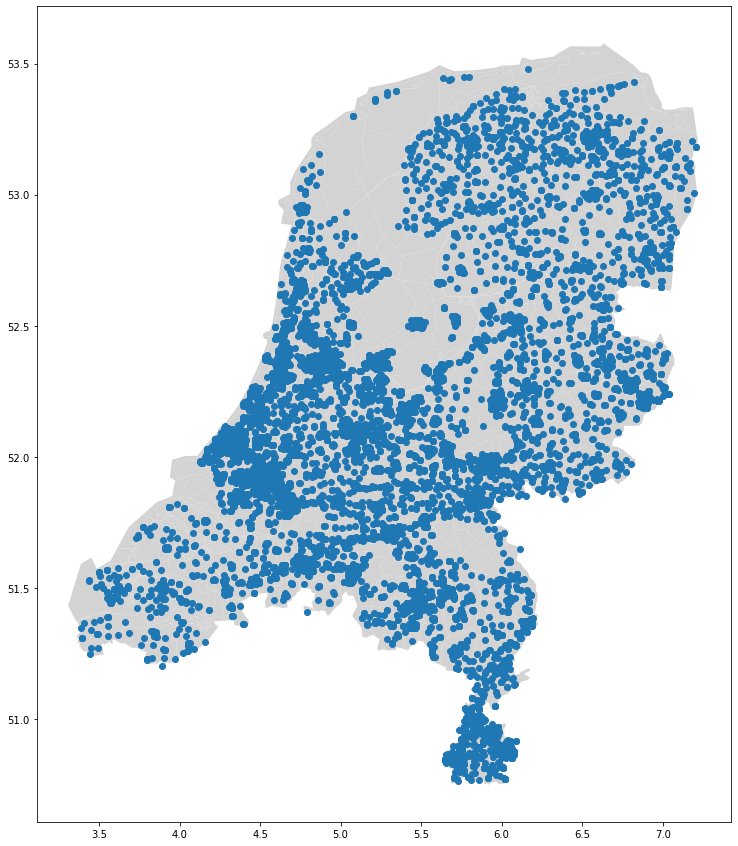

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

Nu we een kaart van nederland met de stemlokalen erop hebben, kunnen we als eerste voorbeeld gaan kijken hoe dit zich verhoudt met de bevolkingsdichtheid. De kaart is opgehaald van het CBS, eerst gaan we kijken hoe de kaart er op zichzelf met dezelfde projectie uitziet.

<AxesSubplot:>

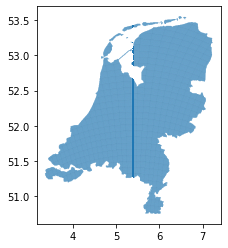

In [17]:
nl_map_cbs = gpd.read_file(r'../data/shape/Netherlands_shapefile/cbs_vk500_2021_v1.gpkg')
nl_map_cbs.to_crs(epsg=4326).plot()

Het verwerken van de 100m bij 100m vierkanten kaart duurde lang (langer dan een half uur) op de laptop, en is dus niet ideaal tenzij we dit niveau van detail écht nodig hebben. Er is namelijk nog een andere kaart met dezelfde gegevens beschikbaar, maar met een grid van 500 bij 500 meter in plaats van 100 bij 100. Laten we dus kijken hoe vaak een stemlokaal dichterbij dan 100 meter van de dichtstbijzijnde andere is. De makkelijkste manier om dat te doen zonder alle punten met alle andere te vergelijken (wat lang duurt), is een extra dataframe maken als een kopie, alle indexen 1 opschuiven (want alle stemlokalen zijn al in een volgorde van clustering), en dan de laagste afstand bekijken.

In [18]:
# Use Rijksdriehoekscoördinaten (EPSG:28992) as this uses meters as unit so we can calculate the distance in meters
df_shifted = df_geojson_clean.to_crs('EPSG:28992')

df_shifted['geometry (shifted)'] = df_shifted['geometry'].shift(periods=1)
df_shifted['distance'] = df_shifted['geometry'].distance(df_shifted['geometry (shifted)'])
df_shifted.sort_values(['distance'], inplace=True, ascending=True)
zero_mask_booth = df_shifted['distance'] == 0.000000
df_shifted = df_shifted[~zero_mask_booth]
print(df_shifted['distance'])

11165         0.002608
1021          0.004853
3196          0.004875
1923          2.693202
3757          3.609362
             ...      
7444     253385.654588
9711     263408.187856
4392     266925.200994
9297     271954.076837
0                  NaN
Name: distance, Length: 11670, dtype: float64


Los van bovenstaande resultaten blijkt het dat de 100m kaart niet dezelfde inwonersgegevens heeft als de 500m kaart. Deze hebben we echter nodig voor de analyse, dus we gaan verder met de 500 bij 500 meter kaart. Laten we nu een projectie proberen te maken met de bevolkingsdichtheid erop om het te vergelijken met de stemlokalen en hun posities en clustering.

In [19]:
print(list(nl_map_cbs))
nl_map_dst = nl_map_cbs.drop(columns=['aantal_mannen', 'aantal_vrouwen', 'aantal_inwoners_0_tot_15_jaar', 'aantal_inwoners_15_tot_25_jaar', 'aantal_inwoners_25_tot_45_jaar', 'aantal_inwoners_45_tot_65_jaar', 'aantal_inwoners_65_jaar_en_ouder', 'percentage_nederlandse_achtergrond', 'percentage_westerse_migr_achtergr', 'percentage_niet_westerse_migr_achtergr', 'aantal_personen_met_uitkering_onder_aowlft', 'aantal_part_huishoudens', 'aantal_eenpersoonshuishoudens', 'aantal_meerpersoonshuishoudens_zonder_kind', 'aantal_eenouderhuishoudens', 'aantal_tweeouderhuishoudens', 'gemiddelde_huishoudensgrootte', 'aantal_woningen', 'aantal_woningen_bouwjaar_voor_1945', 'aantal_woningen_bouwjaar_45_tot_65', 'aantal_woningen_bouwjaar_65_tot_75', 'aantal_woningen_bouwjaar_75_tot_85', 'aantal_woningen_bouwjaar_85_tot_95', 'aantal_woningen_bouwjaar_95_tot_05', 'aantal_woningen_bouwjaar_05_tot_15', 'aantal_woningen_bouwjaar_15_en_later', 'aantal_meergezins_woningen', 'percentage_koopwoningen', 'percentage_huurwoningen', 'aantal_huurwoningen_in_bezit_woningcorporaties', 'aantal_niet_bewoonde_woningen', 'gemiddelde_woz_waarde_woning', 'omgevingsadressendichtheid'])

nl_map_dst

['crs28992res500m', 'aantal_inwoners', 'aantal_mannen', 'aantal_vrouwen', 'aantal_inwoners_0_tot_15_jaar', 'aantal_inwoners_15_tot_25_jaar', 'aantal_inwoners_25_tot_45_jaar', 'aantal_inwoners_45_tot_65_jaar', 'aantal_inwoners_65_jaar_en_ouder', 'percentage_nederlandse_achtergrond', 'percentage_westerse_migr_achtergr', 'percentage_niet_westerse_migr_achtergr', 'aantal_personen_met_uitkering_onder_aowlft', 'aantal_part_huishoudens', 'aantal_eenpersoonshuishoudens', 'aantal_meerpersoonshuishoudens_zonder_kind', 'aantal_eenouderhuishoudens', 'aantal_tweeouderhuishoudens', 'gemiddelde_huishoudensgrootte', 'aantal_woningen', 'aantal_woningen_bouwjaar_voor_1945', 'aantal_woningen_bouwjaar_45_tot_65', 'aantal_woningen_bouwjaar_65_tot_75', 'aantal_woningen_bouwjaar_75_tot_85', 'aantal_woningen_bouwjaar_85_tot_95', 'aantal_woningen_bouwjaar_95_tot_05', 'aantal_woningen_bouwjaar_05_tot_15', 'aantal_woningen_bouwjaar_15_en_later', 'aantal_meergezins_woningen', 'percentage_koopwoningen', 'percentag

,crs28992res500m,aantal_inwoners,stedelijkheid,geometry
0,E2260N6190,-99997,-99997,"MULTIPOLYGON (((226000.000 619000.000, 226000...."
1,E2265N6190,-99997,-99997,"MULTIPOLYGON (((226500.000 619500.000, 227000...."
2,E2270N6190,-99997,-99997,"MULTIPOLYGON (((227000.000 619500.000, 227500...."
3,E2275N6190,-99997,-99997,"MULTIPOLYGON (((227500.000 619500.000, 228000...."
4,E2280N6190,-99997,-99997,"MULTIPOLYGON (((228000.000 619500.000, 228500...."
...,...,...,...,...
151103,E1995N3070,-99997,5,"MULTIPOLYGON (((199500.000 307500.000, 200000...."
151104,E1905N3065,-99997,-99997,"MULTIPOLYGON (((190500.000 307000.000, 191000...."
151105,E1910N3065,-99997,-99997,"MULTIPOLYGON (((191000.000 307000.000, 191500...."
151106,E1920N3065,15,5,"MULTIPOLYGON (((192000.000 307000.000, 192500...."


We kunnen zien dat er gemeente zijn die geen stemlokalen hebben, dit klopt. [In de verkiezingen van 2022 hebben 12 gemeentes niet meegedaan](https://nl.wikipedia.org/wiki/Nederlandse_gemeenteraadsverkiezingen_2022). Er zijn dus in totaal 333 gemeentes met stemlokalen. We willen de bevolkingsdichtheiddata van de gemeentes die niet meededen dus weggooien, hiervoor moeten we eerst kijken welke alleen binnen de gemeentes vallen die we niet willen houden.

In [20]:
print(df_geojson['electionName'])

#get all municipalities that are in the election
gemeentes = df_geojson['electionName'].str.slice(13, -5).drop_duplicates()
print(gemeentes)

0             Gemeenteraad Aa en Hunze 2022
1             Gemeenteraad Aa en Hunze 2022
2             Gemeenteraad Aa en Hunze 2022
3             Gemeenteraad Aa en Hunze 2022
4             Gemeenteraad Aa en Hunze 2022
                        ...                
12591    Gemeenteraad 's-Hertogenbosch 2022
12592    Gemeenteraad 's-Hertogenbosch 2022
12593    Gemeenteraad 's-Hertogenbosch 2022
12594    Gemeenteraad 's-Hertogenbosch 2022
12595    Gemeenteraad 's-Hertogenbosch 2022
Name: electionName, Length: 12596, dtype: object
0             Aa en Hunze
27               Aalsmeer
46                 Aalten
74          Achtkarspelen
95           Alblasserdam
               ...       
11976     Zwartewaterland
11997         Zwijndrecht
12031              Zwolle
12122       's-Gravenhage
12495    's-Hertogenbosch
Name: electionName, Length: 333, dtype: object


In [21]:
#First let's remove the municipalities that don't have an Election from the municipality map
remove_lst = ["Boxtel", "Eemsdelta", "Oisterwijk", "Vught", "Heerhugowaard", "Langedijk", "Boxmeer", "Cuijk", "Sint Anthonis", "Mill en Sint Hubert", "Grave", "Landerd", "Uden", "Brielle", "Hellevoetsluis", "Westvoorne", "Purmerend", "Beemster", "Weesp"]


nl_map_clean = nl_map[~nl_map["GM_NAAM"].isin(remove_lst)]
nl_map_clean = nl_map_clean.query("H2O != 'JA'")
nl_map_clean = nl_map_clean.query("GM_NAAM != 'Buitenland'")


nl_map_election = nl_map[nl_map["GM_NAAM"].isin(gemeentes)]
nl_map_election = nl_map_election.query("H2O != 'JA'")

print("Shape of clean: {}".format(nl_map_clean.shape))
print("Shape of election: {}".format(nl_map_election.shape))

diff = pd.concat([nl_map_election, nl_map_clean]).drop_duplicates(keep=False)
diff

Shape of clean: (333, 38)
Shape of election: (330, 38)


,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
113,GM0164,Hengelo,NEE,1845,2,1332,81049,40776,40273,15,...,6,7,6183,6084,99,2021GM0164,2021,47510.255914,6.183056e+07,"POLYGON ((251978.591 481220.258, 251979.382 48..."
191,GM0373,Bergen (NH.),NEE,819,4,300,29715,14317,15398,12,...,0,3,12023,9896,2127,2021GM0373,2021,57488.474563,9.987418e+07,"POLYGON ((105976.650 529056.951, 106002.347 52..."
328,GM0893,Bergen (L.),NEE,318,5,127,13108,6568,6540,13,...,0,3,10850,10324,525,2021GM0893,2021,61497.563571,1.084951e+08,"POLYGON ((199768.270 409749.960, 199758.060 40..."


Het is een andere vorm omdat deze drie gemeentes een andere format hadden voor de naam van hun verkiezingen, en dus niet op dezelfde manier gefilterd konden worden, ze staan wel in de lijst, dit is dus correct, we gebruiken de clean dataframe.
Nu we dezelfde lijst hebben van gemeentes die in de verkiezingen meededen kunnen we verder.

<AxesSubplot:>

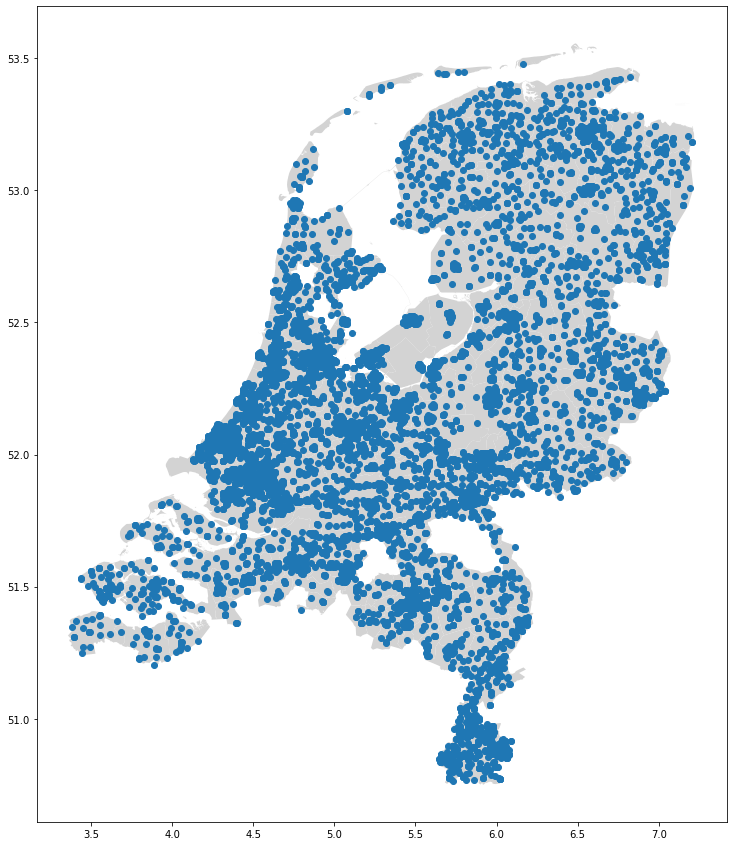

In [22]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map_clean.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

<AxesSubplot:>

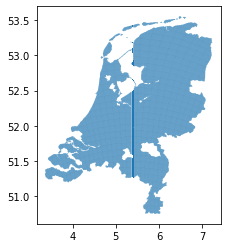

In [23]:
nl_map_dst['savedindex'] = nl_map_dst.index #Save the index values as a new column

intersecting = nl_map_clean.sjoin(nl_map_dst, how='inner')['savedindex'] #Find the polygons that intersect. Keep savedindex as a series

nl_map_dst = nl_map_dst.loc[nl_map_dst.savedindex.isin(intersecting)] #Filter away these, "savedindex is in intersecting"

nl_map_dst.to_crs(epsg=4326).plot()



In [24]:
import folium
from folium import plugins

#Location is Amersfoort, the central point of the continental Netherlands
map = folium.Map(location = [52.155, 5.3875], zoom_start = 9, tiles="cartodbdark_matter", prefer_canvas=True)

nl_map_dst.to_crs(epsg=4326)
#Make sure the index is a string so folium can read it correctly as a key.
nl_map_dst['crs28992res500m'] = nl_map_dst['crs28992res500m'].apply(lambda x: str(x))

nl_map_dst_zero = nl_map_dst.copy()

zero_mask_pop = nl_map_dst['aantal_inwoners'] == -99997
nl_map_dst = nl_map_dst[~zero_mask_pop]
zero_mask_pop2 = nl_map_dst['aantal_inwoners'] == 0
nl_map_dst = nl_map_dst[~zero_mask_pop2]

folium.Choropleth(
    geo_data = nl_map_dst,
    name="Bevolkingsdichtheid",
    data = nl_map_dst,
    columns = ["crs28992res500m", "aantal_inwoners"],
    key_on = 'feature.properties.crs28992res500m',
    fill_color = 'RdPu',
    nan_fill_color= 'white',
    fill_opacity = 0.7,
    nan_fill_opacity = 0.7,
    line_opacity = 0,
    legend_name = 'Bevolkingsdichtheid',
    smooth_factor = 1.0,
    show=False
).add_to(map)
map

# Renders the map to an HTML file and displays it in an embed.
def embed_map(m):
    #from IPython.display import IFrame
    m.save('index.html')
    #return IFrame('index.html', width='100%', height='750px')

In [25]:
gdf_wims_hmp = [[point.xy[1][0], point.xy[0][0]] for point in gdf_wims.geometry]

plugins.HeatMap(gdf_wims_hmp, name="Stemlokalen Heatmap").add_to(map)

folium.LayerControl().add_to(map)



embed_map(map)




In [26]:
nl_map_dst_points = nl_map_dst.copy()
nl_map_dst_points['geometry'] = nl_map_dst_points['geometry'].centroid

nl_map_dst_zero_points = nl_map_dst_zero.copy()
nl_map_dst_zero_points['geometry'] = nl_map_dst_zero_points['geometry'].centroid

nl_map_dst_zero_points

,crs28992res500m,aantal_inwoners,stedelijkheid,geometry,savedindex
2,E2270N6190,-99997,-99997,POINT (227250.000 619250.000),2
3,E2275N6190,-99997,-99997,POINT (227750.000 619250.000),3
4,E2280N6190,-99997,-99997,POINT (228250.000 619250.000),4
7,E2265N6185,-99997,-99997,POINT (226750.000 618750.000),7
8,E2270N6185,-99997,-99997,POINT (227250.000 618750.000),8
...,...,...,...,...,...
151102,E1990N3070,-99997,-99997,POINT (199250.000 307250.000),151102
151103,E1995N3070,-99997,5,POINT (199750.000 307250.000),151103
151105,E1910N3065,-99997,-99997,POINT (191250.000 306750.000),151105
151106,E1920N3065,15,5,POINT (192250.000 306750.000),151106


In [27]:
import numpy as np

from scipy.spatial import cKDTree
from shapely.geometry import Point
#Found on https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

#error bar is +- sqrt(250²*2)m ≈ +-353.553390593m
error = np.sqrt(250**2 + 250**2)
df_nearest = ckdnearest(nl_map_dst_points.to_crs(epsg=28992), gdf_wims_dedupe.to_crs(epsg=28992))
df_nearest.head()



,crs28992res500m,aantal_inwoners,stedelijkheid,geometry,savedindex,Unnamed: 0,_id,Gemeente,CBS gemeentecode,Nummer stembureau,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,dist
0,E2050N6110,5,5,POINT (205250.000 611250.000),267,5710,30871,Schiermonnikoog,GM0088,1,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,1331.950309
1,E2060N6110,10,5,POINT (206250.000 611250.000),269,5710,30871,Schiermonnikoog,GM0088,1,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,688.536284
2,E2055N6105,20,5,POINT (205750.000 610750.000),292,5710,30871,Schiermonnikoog,GM0088,1,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,672.375861
3,E2060N6105,185,5,POINT (206250.000 610750.000),293,5710,30871,Schiermonnikoog,GM0088,1,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,228.220493
4,E2065N6105,335,5,POINT (206750.000 610750.000),294,5710,30871,Schiermonnikoog,GM0088,1,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,389.974214


Het was mooier geweest als we het konden filteren op alleen stemgerechtigden en niet op de gehele populatiedichtheid, maar het CBS geeft geen data vrij die daarbij helpt. Er is een categorie voor 0-14 jaar oude mensen, maar niet alle minderjarigen of niet stemgerechtigde. Het moet dus maar met totale bevolkingsdichtheid om een idee te krijgen.

In [28]:
nl_map_dst_zero_points["aantal_inwoners"].mask(nl_map_dst_zero_points["aantal_inwoners"] == -99997, 0, inplace=True)
nl_map_dst_zero_points.head()
df_nearest_zero = ckdnearest(nl_map_dst_zero_points.to_crs(epsg=28992), gdf_wims_dedupe.to_crs(epsg=28992))
df_nearest_zero["aantal_inwoners"].dropna()
df_nearest_zero["dist"].dropna()
df_nearest_zero

,crs28992res500m,aantal_inwoners,stedelijkheid,geometry,savedindex,Unnamed: 0,_id,Gemeente,CBS gemeentecode,Nummer stembureau,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,dist
0,E2270N6190,0,-99997,POINT (227250.000 619250.000),2,5817,31030,Het Hogeland,GM1966,1,...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17236.920436
1,E2275N6190,0,-99997,POINT (227750.000 619250.000),3,5817,31030,Het Hogeland,GM1966,1,...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17280.014918
2,E2280N6190,0,-99997,POINT (228250.000 619250.000),4,5817,31030,Het Hogeland,GM1966,1,...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17337.427867
3,E2265N6185,0,-99997,POINT (226750.000 618750.000),7,5817,31030,Het Hogeland,GM1966,1,...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,16708.725120
4,E2270N6185,0,-99997,POINT (227250.000 618750.000),8,5817,31030,Het Hogeland,GM1966,1,...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,16738.249149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139997,E1990N3070,0,-99997,POINT (199250.000 307250.000),151102,498,4103,Vaals,GM0981,3,...,NaN,Vaals,Vaals,NaN,"Team verkiezingen, verkiezingen2022@vaals.nl",http://www.vaals.nl/verkiezingen,NaN,NLODSGM0981stembureaus20220316009,3dfcfccd163145698a33b19623c5c3f3,2010.126740
139998,E1995N3070,0,5,POINT (199750.000 307250.000),151103,498,4103,Vaals,GM0981,3,...,NaN,Vaals,Vaals,NaN,"Team verkiezingen, verkiezingen2022@vaals.nl",http://www.vaals.nl/verkiezingen,NaN,NLODSGM0981stembureaus20220316009,3dfcfccd163145698a33b19623c5c3f3,1949.951758
139999,E1910N3065,0,-99997,POINT (191250.000 306750.000),151105,5276,29739,Gulpen-Wittem,GM1729,7,...,NaN,Gulpen-Wittem,Gulpen-Wittem,NaN,info@gulpen-wittem.nl 14 043,https://www.gulpen-wittem.nl/onderwerpen/verki...,NaN,NLODSGM1729stembureaus20220316009,feb9d0a67a2f460f906d0d21e87bf690,2880.233287
140000,E1920N3065,15,5,POINT (192250.000 306750.000),151106,5276,29739,Gulpen-Wittem,GM1729,7,...,NaN,Gulpen-Wittem,Gulpen-Wittem,NaN,info@gulpen-wittem.nl 14 043,https://www.gulpen-wittem.nl/onderwerpen/verki...,NaN,NLODSGM1729stembureaus20220316009,feb9d0a67a2f460f906d0d21e87bf690,2746.345509


In [29]:
df_nearest.sort_values(by=['dist'], inplace=True)
df_nearest[['Gemeente', 'Naam stembureau', 'dist']]

,Gemeente,Naam stembureau,dist
47304,Ridderkerk,Gemeentehuis,3.835321
32815,Baarn,Dorpshuis de Furs,4.000517
5168,Groningen,Dorpshuis De Hoeksteen,5.577246
38975,Montfoort,Zalencentrum St. Joseph,5.703409
67518,Kerkrade,’t Westhoes,7.252446
...,...,...,...
23422,Zeewolde,Het Kruispunt,8207.619943
22478,Lelystad,Gymzaal De Borg,8402.730770
22348,Lelystad,Voormalige Scholengemeenschap De Rietlanden,8540.805874
22477,Lelystad,Voormalige Scholengemeenschap De Rietlanden,9028.790070


In [30]:
def plot_dist(df, label):
    plt.figure(figsize=(13,13))
    df['dist'].plot(kind="hist", weights=df['aantal_inwoners'], figsize=(13,13), fontsize=22, density=False,title="Afstand tot Stemlokaal per 500 x 500 m vierkant (minimaal 5 mensen in het vierkant) Staffel {}".format(label), log=True).set_ylabel('Bevolking (Millioenen)')
    plt.figure(figsize=(13,13))
    df.plot.scatter(x = 'aantal_inwoners', y = 'dist', figsize=(13,13), fontsize=22, title="Afstand tot Stemlokaal per 500 x 500 m vierkant (minimaal 5 mensen in het vierkant) Staffel {}".format(label), xlabel="Inwoners per 500m² (laagste is 5)", ylabel="Afstand tot stemlokaal (meter)")
    

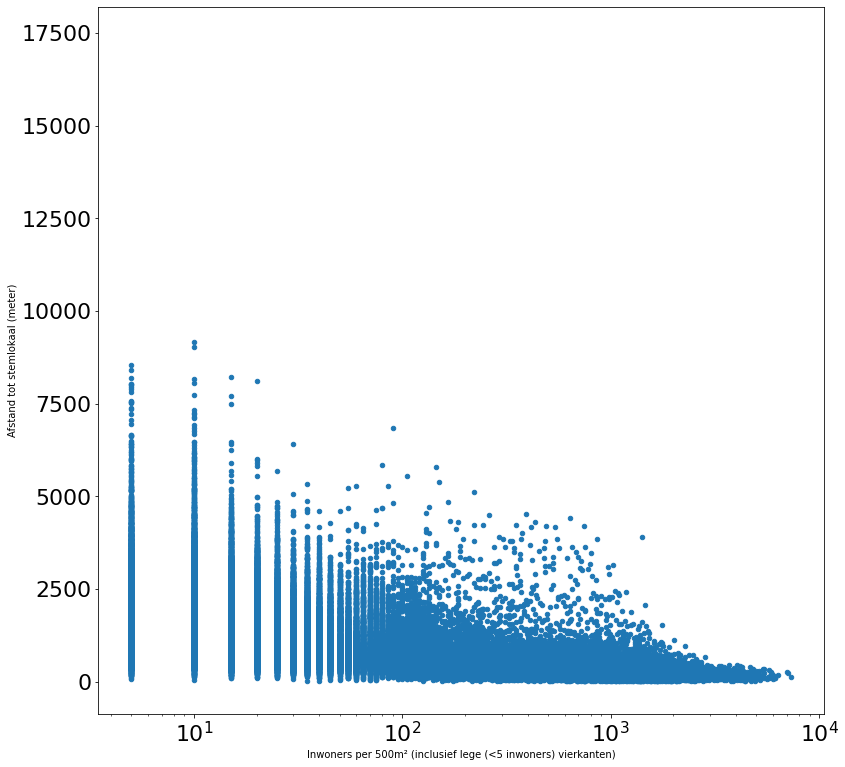

In [31]:
ax_nearest_zero = df_nearest_zero.plot.scatter(x = 'aantal_inwoners', y = 'dist', figsize=(13,13), fontsize=22, xlabel="Inwoners per 500m² (inclusief lege (<5 inwoners) vierkanten)", ylabel="Afstand tot stemlokaal (meter)")


ax_nearest_zero.set_xscale('log')
#ax_nearest_zero.set_yscale('log')


In [32]:
FIGSIZE = (13, 13)
def plot_bargraph_with_groupings(df, groupby, colourby, title, xlabel, ylabel):

    import matplotlib.patches as mpatches


    # Makes the bargraph.
    ax = df[groupby].value_counts().plot(kind='bar',
                                         figsize=FIGSIZE,
                                         title=title)
    

    # display the graph.
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

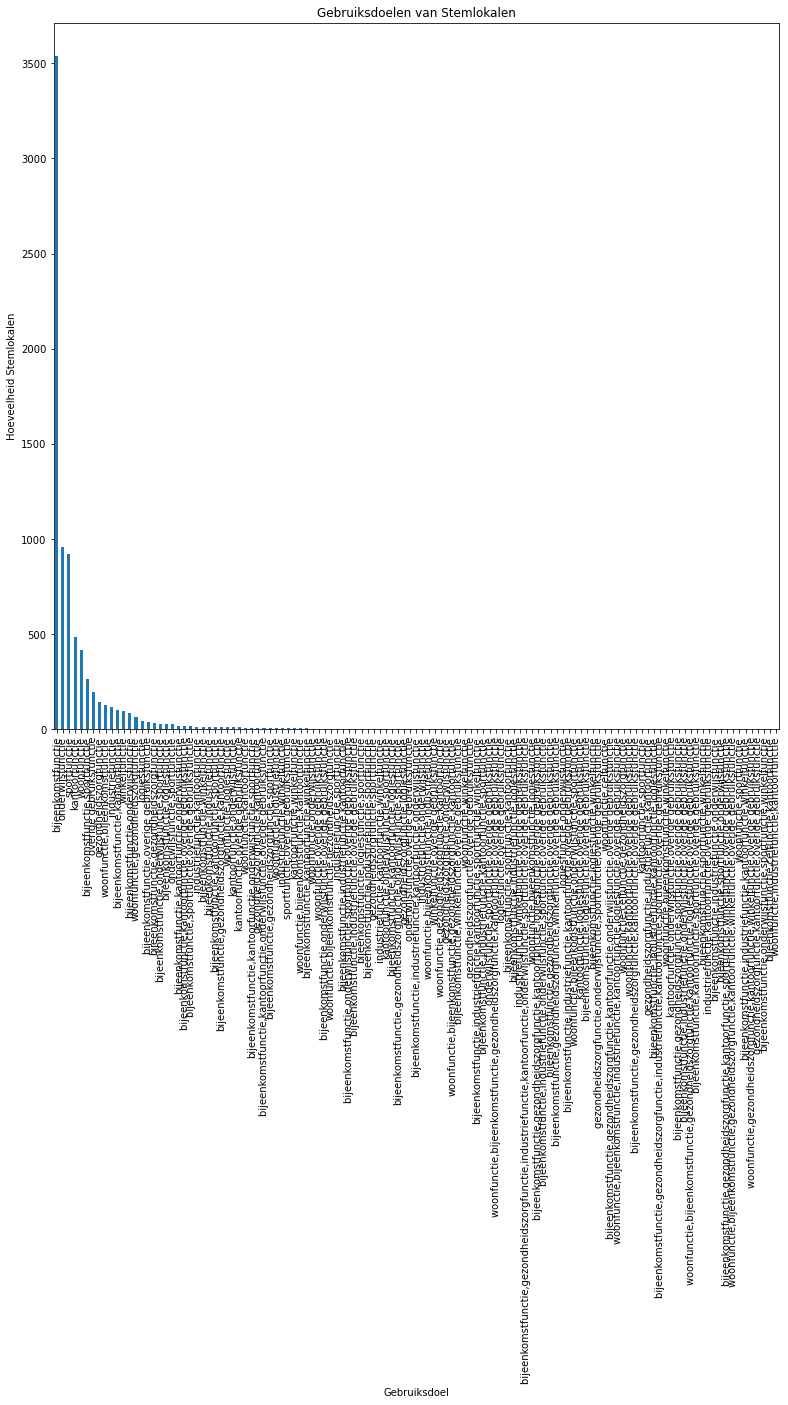

In [33]:
plot_bargraph_with_groupings(gdf_wims_dedupe, 'Gebruiksdoel van het gebouw', 'Gemeente', 'Gebruiksdoelen van Stemlokalen', 'Gebruiksdoel', 'Hoeveelheid Stemlokalen')

Dit is onbruikbaar, de categorieën moeten elk één balkje zijn, niet zoals dit.

In [34]:
def plot_use (df, label):
    plt.figure(figsize=(13,13))
    df_exploded = df.drop('Gebruiksdoel van het gebouw', axis=1).join(df['Gebruiksdoel van het gebouw'].str.split(',', expand=True).stack().reset_index(level=1,drop=True).rename('Gebruiksdoel van het gebouw'))
    #print(df_exploded)
    plot_bargraph_with_groupings(df_exploded, 'Gebruiksdoel van het gebouw', 'Gemeente', 'Gebruiksdoelen van Stemlokalen Staffel {}'.format(label), 'Gebruiksdoel', 'Hoeveelheid Stemlokalen')
    print("Staffel: {}".format(label))
    print(df_exploded['Gebruiksdoel van het gebouw'].value_counts())
    
    

In [35]:

wims_count = gdf_wims_dedupe['Gemeente'].value_counts()


geojson_rename = df_geojson_dedupe.rename(columns = {'electionName': 'Gemeente'})
geojson_count = geojson_rename['Gemeente'].str.slice(13, -5).value_counts()

pd.concat([geojson_count, wims_count]).drop_duplicates(keep=False)


Amsterdam              456
Rotterdam              398
's-Gravenhage          271
Utrecht                162
Breda                   90
Eindhoven               86
Groningen               85
Apeldoorn               71
Enschede                69
Alphen aan den Rijn     66
Leiden                  52
Deventer                51
West Betuwe             37
Waadhoeke               33
Amsterdam              382
Rotterdam              375
's-Gravenhage          258
Utrecht                161
Groningen              122
Breda                   89
Haarlemmermeer          79
Nijmegen                74
's-Hertogenbosch        40
Het Hogeland            39
Zoetermeer              38
Staphorst                2
Name: Gemeente, dtype: int64

In [56]:
standard_14 = '2022-03-14T07:30:00 tot 2022-03-14T21:00:00'
standard_15 = '2022-03-15T07:30:00 tot 2022-03-15T21:00:00'
standard_16 = '2022-03-16T07:30:00 tot 2022-03-16T21:00:00'


nan_value = float("NaN")
gdf_wims_dedupe.replace(" ", nan_value, inplace = True)
gdf_wims_dedupe.replace("  ", nan_value, inplace = True)

wims_nonstandaard_14 = gdf_wims_dedupe.dropna(subset=['Openingstijden 14-03-2022']).loc[gdf_wims_dedupe['Openingstijden 14-03-2022'] != standard_14]
wims_nonstandaard_15 = gdf_wims_dedupe.dropna(subset=['Openingstijden 15-03-2022']).loc[gdf_wims_dedupe['Openingstijden 15-03-2022'] != standard_15]
wims_nonstandaard_16 = gdf_wims_dedupe.dropna(subset=['Openingstijden 16-03-2022']).loc[gdf_wims_dedupe['Openingstijden 16-03-2022'] != standard_16]
wims_standaard_14 = gdf_wims_dedupe.loc[gdf_wims_dedupe['Openingstijden 14-03-2022'] == standard_14]
wims_standaard_15 = gdf_wims_dedupe.loc[gdf_wims_dedupe['Openingstijden 15-03-2022'] == standard_15]
wims_standaard_16 = gdf_wims_dedupe.loc[gdf_wims_dedupe['Openingstijden 16-03-2022'] == standard_16]

In [37]:
gdf_wims_times = gdf_wims_dedupe.loc[:, ('Openingstijden 14-03-2022','Openingstijden 15-03-2022','Openingstijden 16-03-2022', 'UUID', 'Gemeente', 'CBS gemeentecode')]
gdf_wims_split = gdf_wims_times
gdf_wims_split[['Openingstijden 14-03-2022 van', 'Openingstijden 14-03-2022 tot']] = gdf_wims_times['Openingstijden 14-03-2022'].str.split(' tot ',1 , expand=True)
gdf_wims_split[['Openingstijden 15-03-2022 van', 'Openingstijden 15-03-2022 tot']] = gdf_wims_split['Openingstijden 15-03-2022'].str.split(' tot ',1 , expand=True)
gdf_wims_split[['Openingstijden 16-03-2022 van', 'Openingstijden 16-03-2022 tot']] = gdf_wims_split['Openingstijden 16-03-2022'].str.split(' tot ',1 , expand=True)

gdf_wims_split

,Openingstijden 14-03-2022,Openingstijden 15-03-2022,Openingstijden 16-03-2022,UUID,Gemeente,CBS gemeentecode,Openingstijden 14-03-2022 van,Openingstijden 14-03-2022 tot,Openingstijden 15-03-2022 van,Openingstijden 15-03-2022 tot,Openingstijden 16-03-2022 van,Openingstijden 16-03-2022 tot
0,NaN,NaN,2022-03-16T10:00:00 tot 2022-03-16T13:00:00,3a612b2151fa4ab491b9e331355e6258,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T10:00:00,2022-03-16T13:00:00
1,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,9a01d765af0a467ea37f08d92db114ba,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
2,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,fc5869d33fbc4b06be659149fa615f4c,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
3,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,4427cc0b39e040ba8f75c333f19d66f0,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
4,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,a893bb9add324ce29769f1c39afcc48d,Valkenswaard,GM0858,2022-03-14T07:30:00,2022-03-14T21:00:00,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
9270,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,f744546cd6894e5e9a4db4bbfd81b4ee,Gennep,GM0907,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
9271,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,1270081b1dc74cd7bea0f45973650408,Gennep,GM0907,2022-03-14T07:30:00,2022-03-14T21:00:00,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
9272,NaN,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,447c7742604345139e41def4cf1e4d3c,Gennep,GM0907,NaN,NaN,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
9273,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,049cfd258c174bc49abf17883396d083,Gennep,GM0907,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00


In [38]:
gdf_wims_split[['Openingstijden 14-03-2022 van','Openingstijden 15-03-2022 van','Openingstijden 16-03-2022 van', 'Openingstijden 14-03-2022 tot', 'Openingstijden 15-03-2022 tot','Openingstijden 16-03-2022 tot']] = gdf_wims_split[['Openingstijden 14-03-2022 van','Openingstijden 15-03-2022 van','Openingstijden 16-03-2022 van','Openingstijden 14-03-2022 tot','Openingstijden 15-03-2022 tot','Openingstijden 16-03-2022 tot']].apply(pd.to_datetime, errors='coerce')
gdf_wims_split

,Openingstijden 14-03-2022,Openingstijden 15-03-2022,Openingstijden 16-03-2022,UUID,Gemeente,CBS gemeentecode,Openingstijden 14-03-2022 van,Openingstijden 14-03-2022 tot,Openingstijden 15-03-2022 van,Openingstijden 15-03-2022 tot,Openingstijden 16-03-2022 van,Openingstijden 16-03-2022 tot
0,NaN,NaN,2022-03-16T10:00:00 tot 2022-03-16T13:00:00,3a612b2151fa4ab491b9e331355e6258,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 10:00:00,2022-03-16 13:00:00
1,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,9a01d765af0a467ea37f08d92db114ba,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
2,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,fc5869d33fbc4b06be659149fa615f4c,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
3,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,4427cc0b39e040ba8f75c333f19d66f0,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
4,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,a893bb9add324ce29769f1c39afcc48d,Valkenswaard,GM0858,2022-03-14 07:30:00,2022-03-14 21:00:00,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
9270,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,f744546cd6894e5e9a4db4bbfd81b4ee,Gennep,GM0907,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
9271,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,1270081b1dc74cd7bea0f45973650408,Gennep,GM0907,2022-03-14 07:30:00,2022-03-14 21:00:00,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
9272,NaN,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,447c7742604345139e41def4cf1e4d3c,Gennep,GM0907,NaT,NaT,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
9273,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,049cfd258c174bc49abf17883396d083,Gennep,GM0907,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00


In [39]:
import datetime as dt
import numpy as np

def datesplit(df, column):

    df = df.dropna(subset = ['{} van'.format(column)])
    df1 = df.rename(columns={'{} van'.format(column):'vandate','{} tot'.format(column):'totdate', 'UUID':'UUID'})
    return  (pd.concat([pd.Series(r.UUID,pd.date_range(r.vandate, r.totdate, freq='0.5H')) 
                        for r in df1.itertuples()])
               .rename_axis('Openingstijden')
               .reset_index(name='UUID'))
def plot_opening(df, label):
    print("Open op 14 maart groep {}: {}".format(label, df[df['Openingstijden 15-03-2022 van'].isnull()][df['Openingstijden 16-03-2022 van'].isnull()]['Openingstijden 14-03-2022 van'].count()))
    print("Open op 15 maart groep {}: {}".format(label, df[df['Openingstijden 14-03-2022 van'].isnull()][df['Openingstijden 16-03-2022 van'].isnull()]['Openingstijden 15-03-2022 van'].count()))
    print("Open op 16 maart groep {}: {}".format(label, df[df['Openingstijden 14-03-2022 van'].isnull()][df['Openingstijden 15-03-2022 van'].isnull()]['Openingstijden 16-03-2022 van'].count()))

    print("Open op 14 én 15 maart groep {}: {}".format(label, df[df['Openingstijden 16-03-2022 van'].isnull()].dropna(subset=['Openingstijden 15-03-2022 van'])['Openingstijden 14-03-2022 van'].count()))
    print("Open op 14 én 16 maart groep {}: {}".format(label, df[df['Openingstijden 15-03-2022 van'].isnull()].dropna(subset=['Openingstijden 16-03-2022 van'])['Openingstijden 14-03-2022 van'].count()))
    print("Open op 15 én 16 maart groep {}: {}".format(label, df[df['Openingstijden 14-03-2022 van'].isnull()].dropna(subset=['Openingstijden 15-03-2022 van'])['Openingstijden 16-03-2022 van'].count()))
    print("Open op 14, 15 én 16 maart groep {}: {}".format(label, df.dropna(subset=['Openingstijden 16-03-2022 van', 'Openingstijden 15-03-2022 van'])['Openingstijden 14-03-2022 van'].count()))

    opening = np.datetime64('2022-03-16 07:30:00')
    closing = np.datetime64('2022-03-16 21:00:00')

    #print(df[(df['Openingstijden 16-03-2022 van'] == opening)])
    df_standard = df[(df['Openingstijden 16-03-2022 van'] == opening) & (df['Openingstijden 16-03-2022 tot'] == closing)]

    print("Aantal stemlokalen open op standaard tijden 16 Maart in staffel {}: {}".format(label, df_standard['Openingstijden 14-03-2022 van'].count()))

    plt.figure(figsize=(13,13))
    wims_datesplit_14 = df.loc[:, ('Openingstijden 14-03-2022 van','Openingstijden 14-03-2022 tot', 'UUID')]
    wims_datesplit_15 = df.loc[:, ('Openingstijden 15-03-2022 van','Openingstijden 15-03-2022 tot', 'UUID')]
    wims_datesplit_16 = df.loc[:, ('Openingstijden 16-03-2022 van','Openingstijden 16-03-2022 tot', 'UUID')]
    wims_datesplit_14 = datesplit(wims_datesplit_14, 'Openingstijden 14-03-2022')
    wims_datesplit_15 = datesplit(wims_datesplit_15, 'Openingstijden 15-03-2022')
    wims_datesplit_16 = datesplit(wims_datesplit_16, 'Openingstijden 16-03-2022')

    wims_datesplit_14.reset_index()
    wims_datesplit_15.reset_index()
    wims_datesplit_16.reset_index()

    #wims_datesplit_14.info()
    #wims_datesplit_15.info()
    #wims_datesplit_16.info()

    
    wims_datestack = pd.concat([wims_datesplit_14, wims_datesplit_15], ignore_index=True)
    wims_datestack = pd.concat([wims_datestack, wims_datesplit_16], ignore_index=True)
    
    wims_datestack.set_index('Openingstijden', drop=False, inplace=True)

    #print(wims_datestack['Openingstijden'].unique())

    xticks = []
    xticklabels = []
    datetimecount = 0
    for datetime in wims_datestack.groupby(pd.Grouper(freq='30Min'))['Openingstijden'].unique():
        if (datetime.size > 0):
            xticks.append(datetime.ravel()[0])
            if(datetimecount % 6 == 0):
                ts = pd.to_datetime(datetime.ravel()[0])
                #hardcoded for the data, sloppy code, quick fix, only applies to timestamps with 7 minute changes to reality
                if (ts.minute == 7):
                    ts = ts - dt.timedelta(minutes=7)
                xticklabels.append(ts.strftime("%m-%d %H:%M"))
            else:
                xticklabels.append(" ")
        else:
            xticks.append("")
            xticklabels.append("")
        datetimecount += 1


    wims_datestack.groupby(pd.Grouper(freq='30Min')).count().plot(kind='bar', y='Openingstijden',width=1, figsize=(25, 25), title="Openingstijden stemlokalen staffel {}".format(label), log=True).set_xticklabels(xticklabels, rotation=-45, ha="left", rotation_mode="anchor")
    

    
    dfg = wims_datestack.groupby(pd.Grouper(freq='30Min')).count()
    dfg['Staffel'] = label

    global wims_datestack_grouped
    if (label != 'totaal'):
        wims_datestack_grouped = pd.concat([wims_datestack_grouped, dfg])
    wims_datestack.to_csv(path_or_buf='../data/export/openingstijden_staffel_{}.csv'.format(label), sep=';', na_rep='', header=True, date_format = '%m-%d %H:%M')


    #wims_datesplit_16.groupby(wims_datesplit_16["Openingstijden 16-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 16-03-2022')
    #wims_datesplit_16.groupby(pd.Grouper(freq='30Min')).count().plot(kind='bar', y='Openingstijden 16-03-2022')
    #wims_datesplit_15.groupby(wims_datesplit_15["Openingstijden 15-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 15-03-2022')
    #wims_datesplit_14.groupby(wims_datesplit_14["Openingstijden 14-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 14-03-2022')


In [40]:
df_stemger = pd.read_excel('../data/Maatwerk_kiesgerechtigd_per_gemeente_def.xlsx', sheet_name='Tabel 1', header=0, skiprows= [0,1,3,5,6,7,344,345])
df_stemger_clean = df_stemger[df_stemger['gemeentecode'].isin(nl_map_clean['GM_CODE'])]

bins = [0, 10, 30, 60, 100, 350, float("inf")]
labels = ['1; 0-10.000 stemgerechtigden', '2; 10.000-30.000 stemgerechtigden', '3; 30.000-60.000 stemgerechtigden', '4; 60.000-100.000 stemgerechtigden', '5; 100.000-350.000 stemgerechtigden', '6; >350.000 stemgerechtigden']

df_stemger_clean['binned'] = pd.cut(df_stemger_clean['Kiesgerechtigde bevolking'], bins, labels=labels)


In [41]:
def filter_binned(df1, df2):
    return df1[df1['CBS gemeentecode'].isin(df2['gemeentecode'])]

In [85]:
open_standaard = {
        'dag': [],
        'standaard': [],
        'aantal': [],
        'staffel': []
    }

def print_opening_standard(df, label, day, standard):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    print("Staffel: {}, dag: {}, {}open op standaard dagen, stemlokalen: {}".format(label, day, standard, len(filter_binned(df, df_stemger_label).index)))
    global open_standaard
    open_standaard['dag'].append(day)
    open_standaard['aantal'].append(len(filter_binned(df, df_stemger_label).index))
    open_standaard['staffel'].append(label)
    if (standard == 'niet '):
        open_standaard['standaard'].append(False)
    else:
        open_standaard['standaard'].append(True)
for label in labels:
    print_opening_standard(wims_standaard_14, label, "14 maart", "")
    print_opening_standard(wims_standaard_15, label, "15 maart", "")
    print_opening_standard(wims_standaard_16, label, "16 maart", "")
    print_opening_standard(wims_nonstandaard_14, label, "14 maart", "niet ")
    print_opening_standard(wims_nonstandaard_15, label, "15 maart", "niet ")
    print_opening_standard(wims_nonstandaard_16, label, "16 maart", "niet ")


Staffel: 1; 0-10.000 stemgerechtigden, dag: 14 maart, open op standaard dagen, stemlokalen: 28
Staffel: 1; 0-10.000 stemgerechtigden, dag: 15 maart, open op standaard dagen, stemlokalen: 29
Staffel: 1; 0-10.000 stemgerechtigden, dag: 16 maart, open op standaard dagen, stemlokalen: 126
Staffel: 1; 0-10.000 stemgerechtigden, dag: 14 maart, niet open op standaard dagen, stemlokalen: 0
Staffel: 1; 0-10.000 stemgerechtigden, dag: 15 maart, niet open op standaard dagen, stemlokalen: 4
Staffel: 1; 0-10.000 stemgerechtigden, dag: 16 maart, niet open op standaard dagen, stemlokalen: 3
Staffel: 2; 10.000-30.000 stemgerechtigden, dag: 14 maart, open op standaard dagen, stemlokalen: 421
Staffel: 2; 10.000-30.000 stemgerechtigden, dag: 15 maart, open op standaard dagen, stemlokalen: 427
Staffel: 2; 10.000-30.000 stemgerechtigden, dag: 16 maart, open op standaard dagen, stemlokalen: 2150
Staffel: 2; 10.000-30.000 stemgerechtigden, dag: 14 maart, niet open op standaard dagen, stemlokalen: 15
Staffel:

[Text(0, 0, '14 maart'), Text(1, 0, '15 maart'), Text(2, 0, '16 maart')]

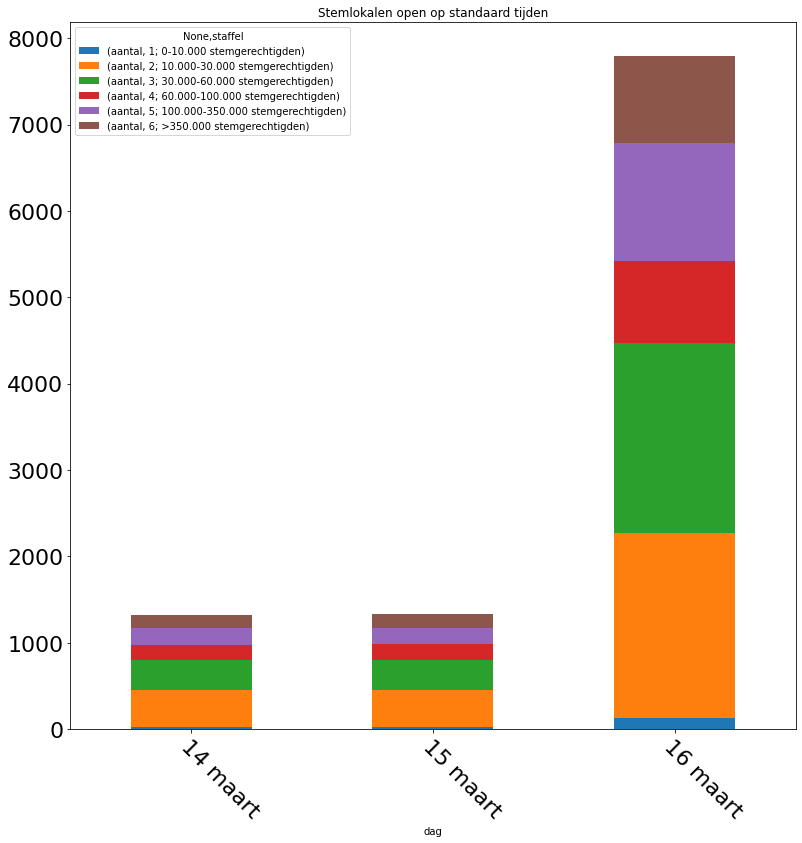

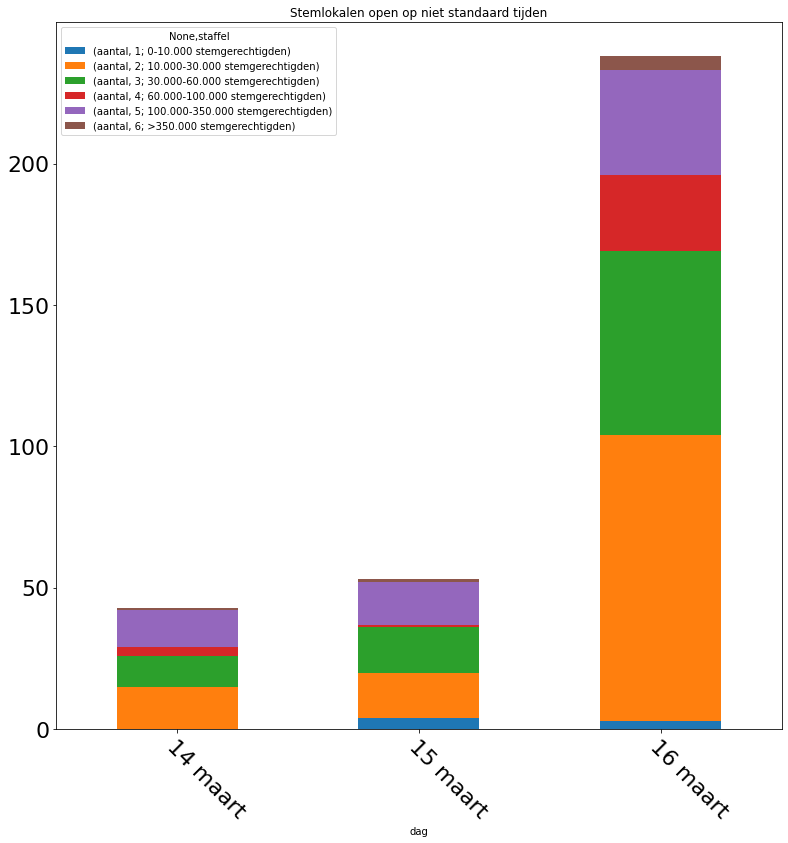

In [99]:
df_open_standaard_full = pd.DataFrame(open_standaard)

df_open_standaard_plot = df_open_standaard_full[df_open_standaard_full['standaard']].pivot(index='dag', columns=['staffel'], values=['aantal'])

df_open_nonstandaard = pd.DataFrame(open_standaard)

df_open_nonstandaard_plot = df_open_nonstandaard[~df_open_nonstandaard['standaard']].pivot(index='dag', columns=['staffel'], values=['aantal'])

dagen_standaard = sorted(list(dict.fromkeys(open_standaard['dag'])))

ax_open_standaard = df_open_standaard_plot.plot(title='Stemlokalen open op standaard tijden',kind="bar", stacked=True, fontsize=22, figsize=(13,13))

ax_open_nonstandaard = df_open_nonstandaard_plot.plot(title='Stemlokalen open op niet standaard tijden', kind="bar", stacked=True, fontsize=22, figsize=(13,13))

ax_open_standaard.set_xticklabels(dagen_standaard, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")

ax_open_nonstandaard.set_xticklabels(dagen_standaard, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")

Open op 14 maart groep 1; 0-10.000 stemgerechtigden: 0
Open op 15 maart groep 1; 0-10.000 stemgerechtigden: 3
Open op 16 maart groep 1; 0-10.000 stemgerechtigden: 95
Open op 14 én 15 maart groep 1; 0-10.000 stemgerechtigden: 0
Open op 14 én 16 maart groep 1; 0-10.000 stemgerechtigden: 4
Open op 15 én 16 maart groep 1; 0-10.000 stemgerechtigden: 6
Open op 14, 15 én 16 maart groep 1; 0-10.000 stemgerechtigden: 24
Aantal stemlokalen open op standaard tijden 16 Maart in staffel 1; 0-10.000 stemgerechtigden: 28
Open op 14 maart groep 2; 10.000-30.000 stemgerechtigden: 5
Open op 15 maart groep 2; 10.000-30.000 stemgerechtigden: 4
Open op 16 maart groep 2; 10.000-30.000 stemgerechtigden: 1804
Open op 14 én 15 maart groep 2; 10.000-30.000 stemgerechtigden: 5
Open op 14 én 16 maart groep 2; 10.000-30.000 stemgerechtigden: 13
Open op 15 én 16 maart groep 2; 10.000-30.000 stemgerechtigden: 21
Open op 14, 15 én 16 maart groep 2; 10.000-30.000 stemgerechtigden: 413
Aantal stemlokalen open op standa

<Figure size 936x936 with 0 Axes>

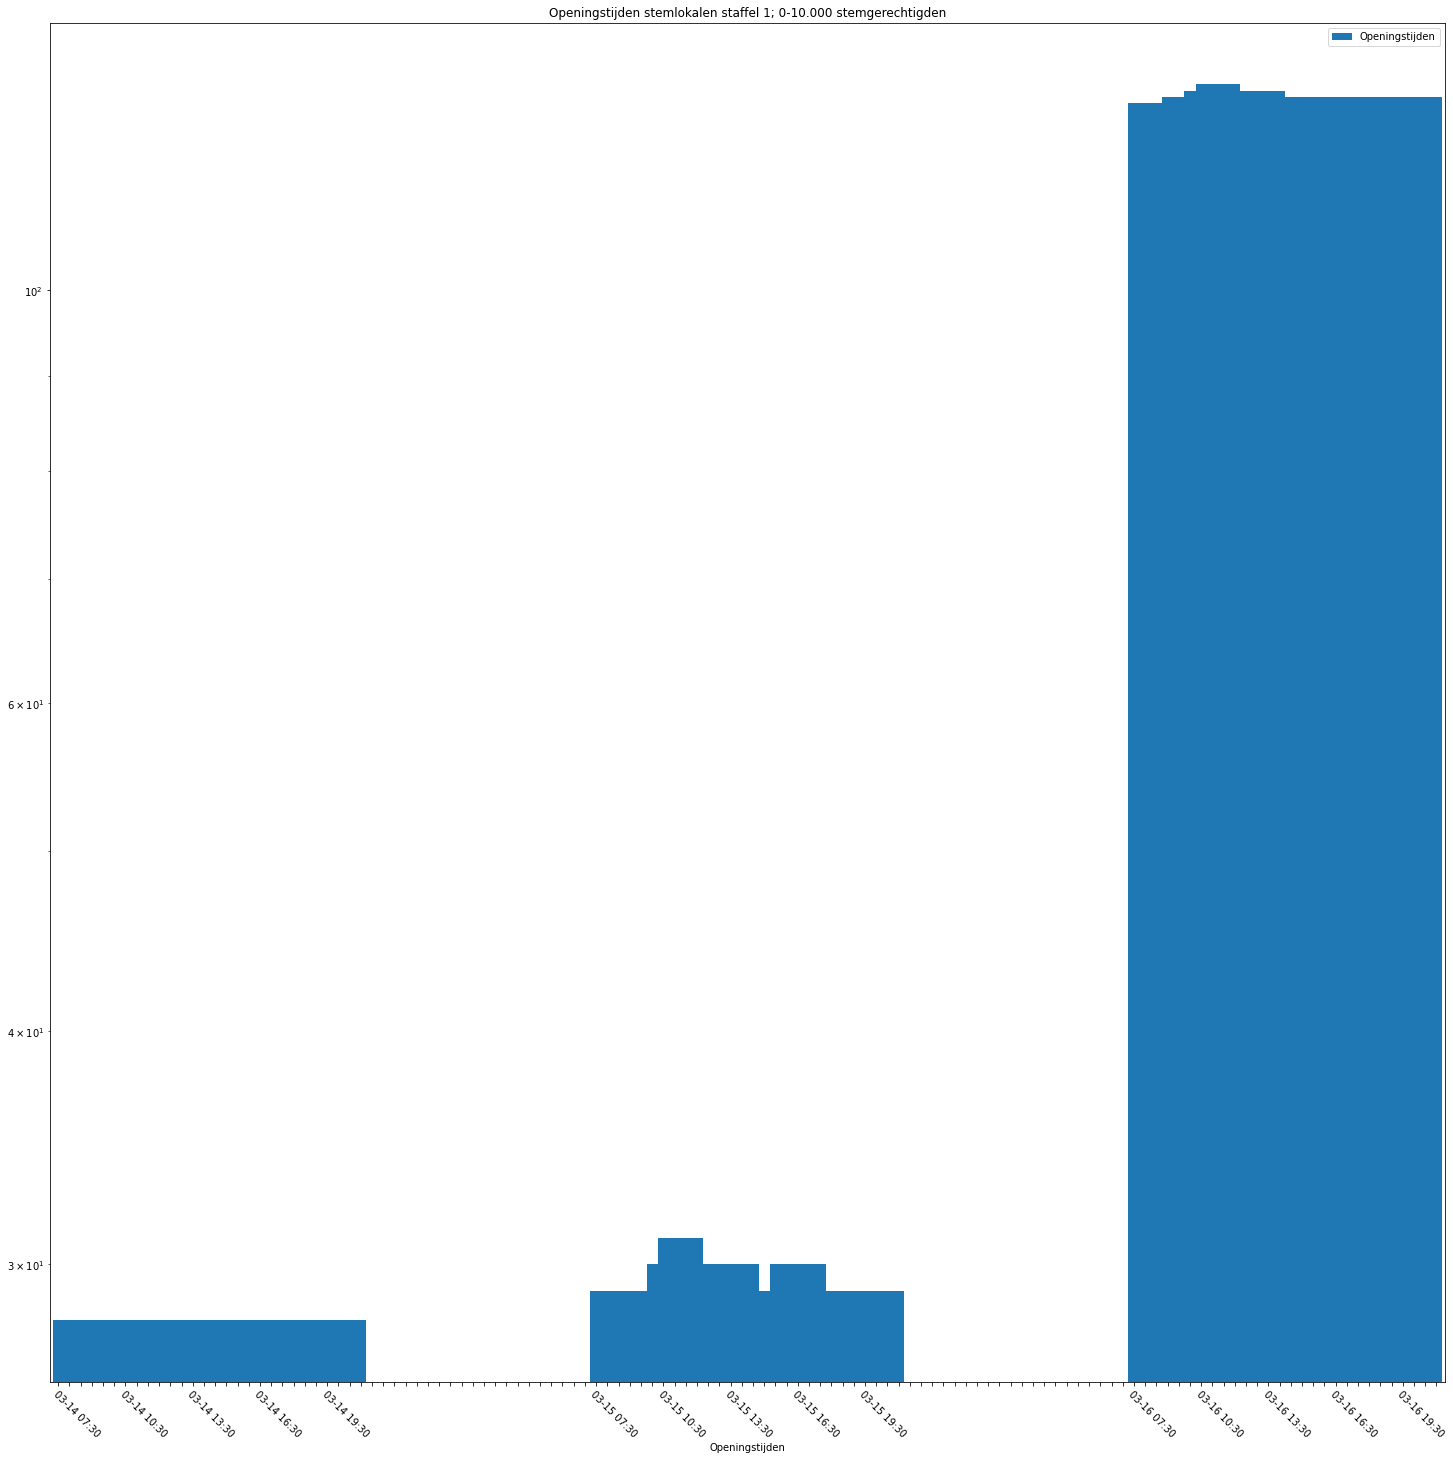

<Figure size 936x936 with 0 Axes>

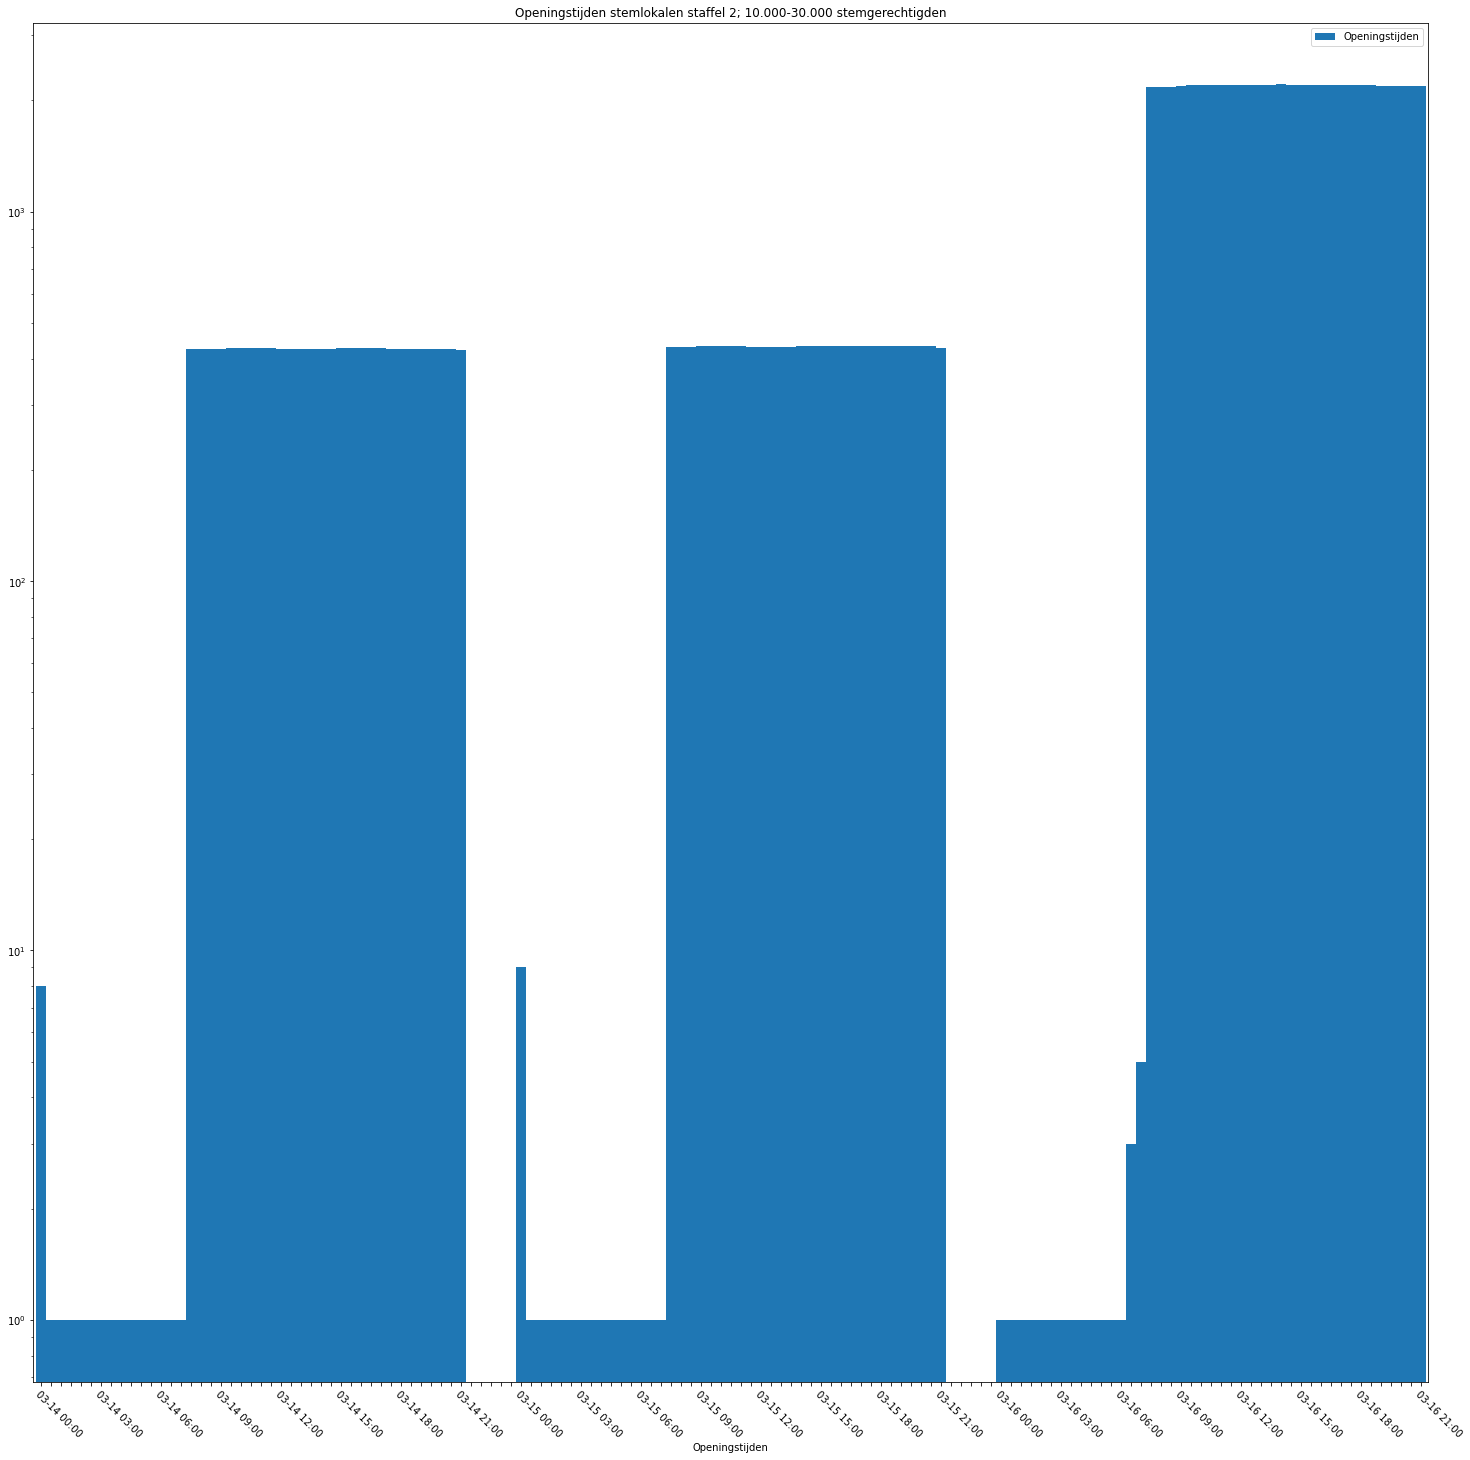

<Figure size 936x936 with 0 Axes>

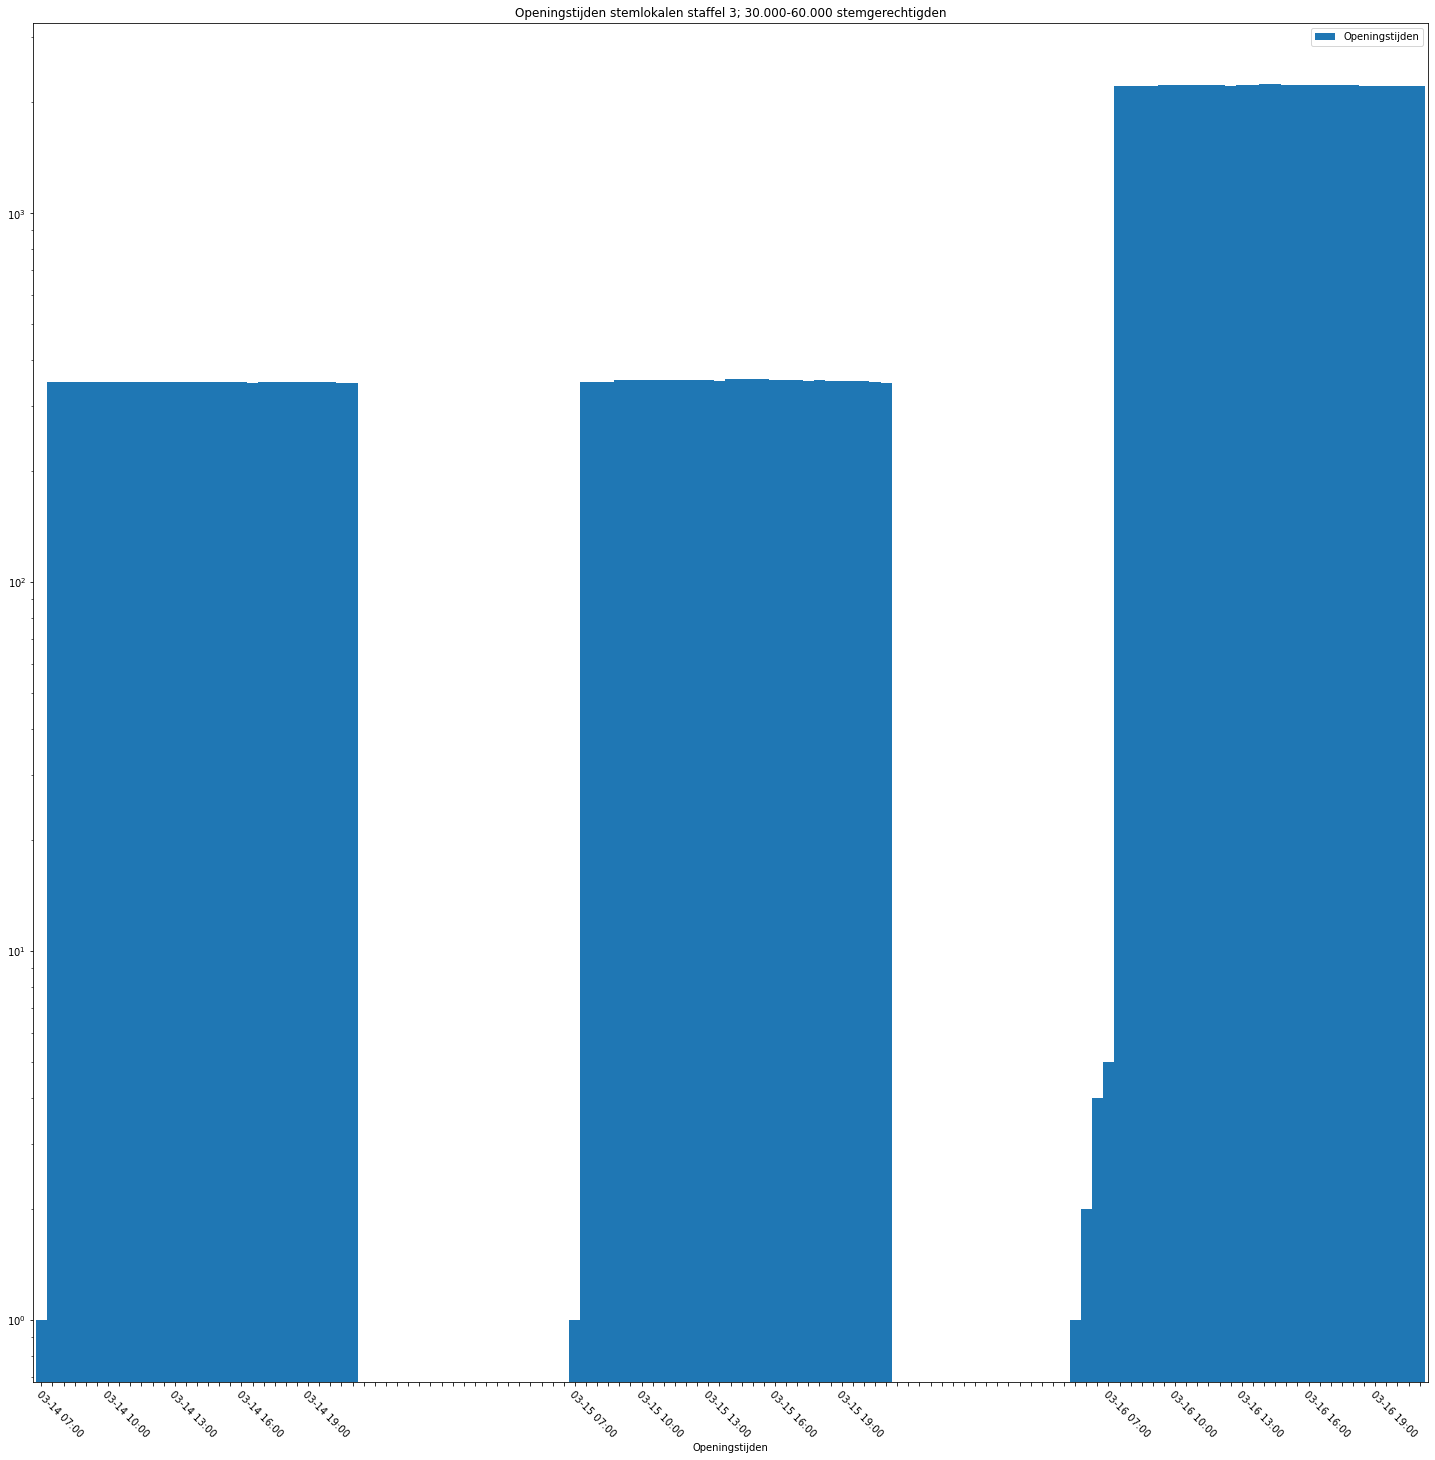

<Figure size 936x936 with 0 Axes>

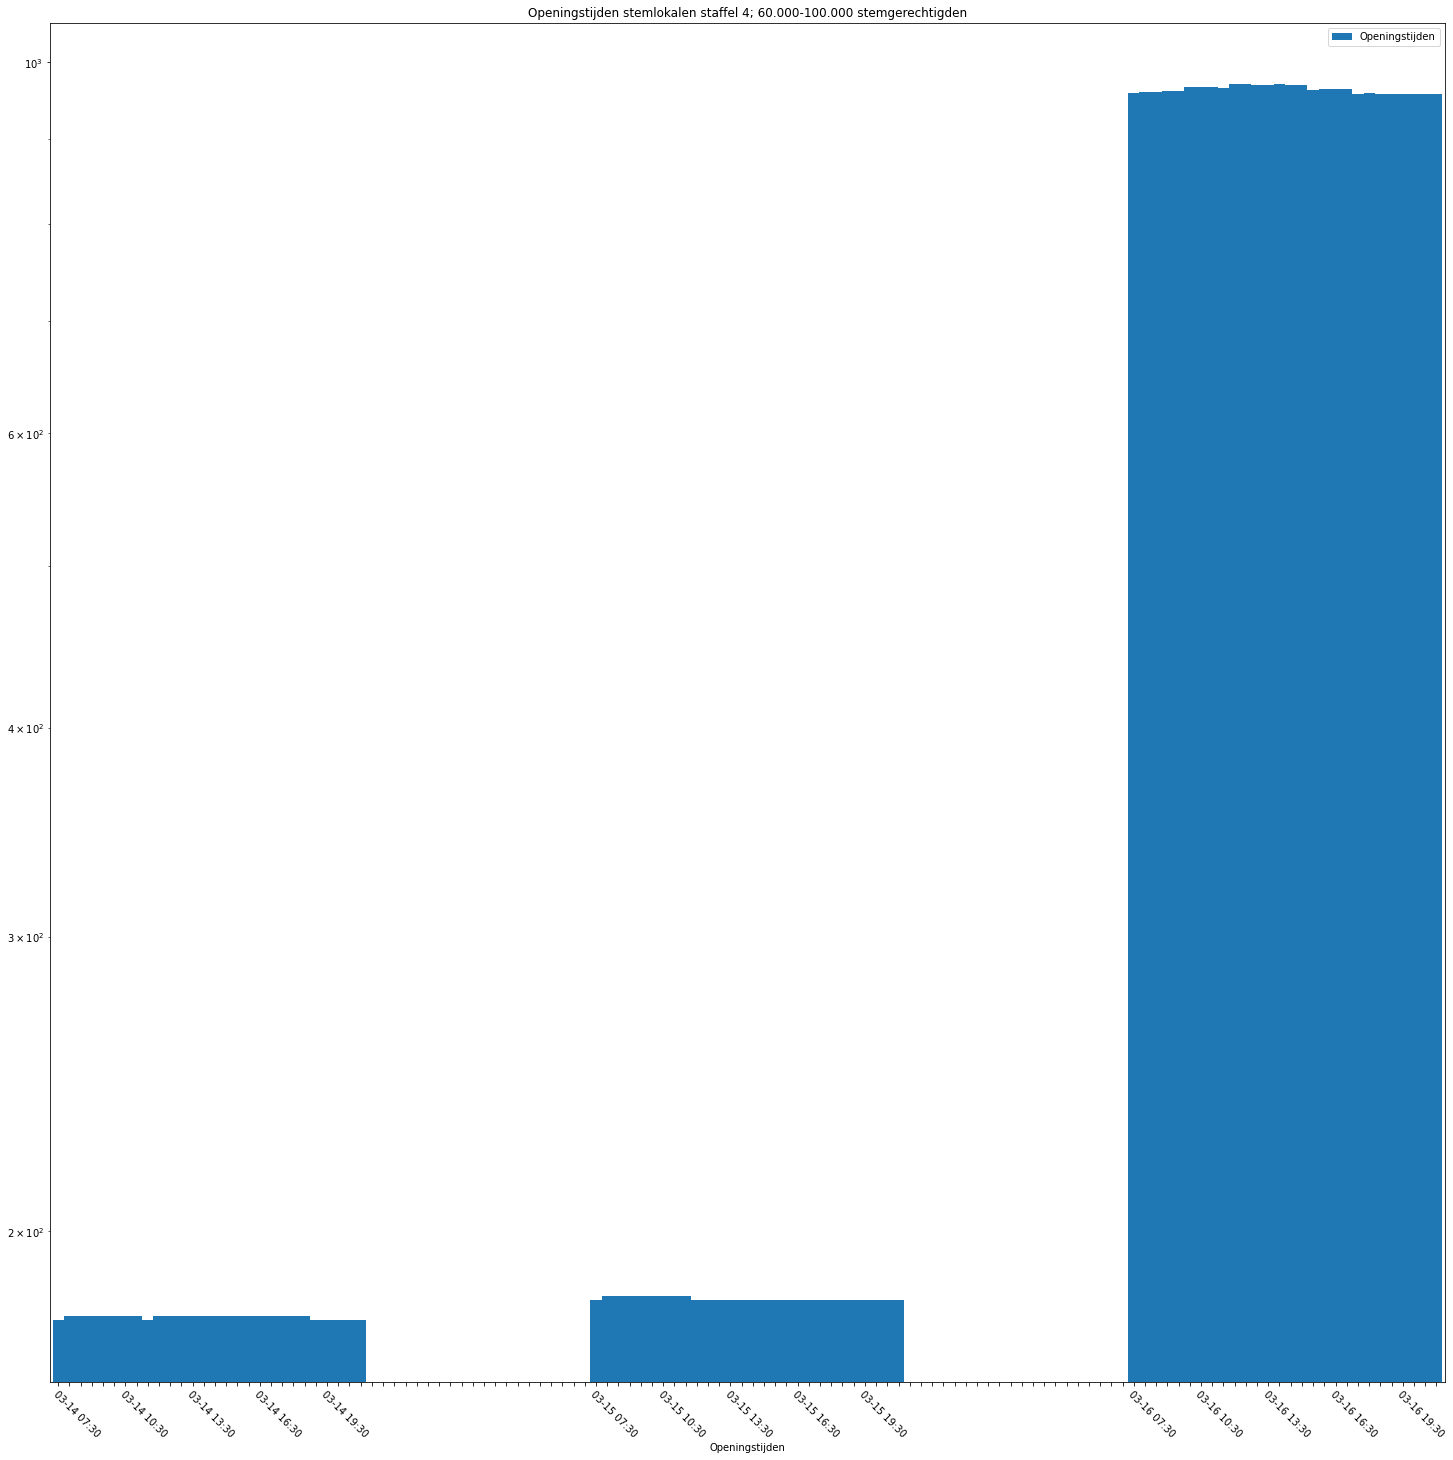

<Figure size 936x936 with 0 Axes>

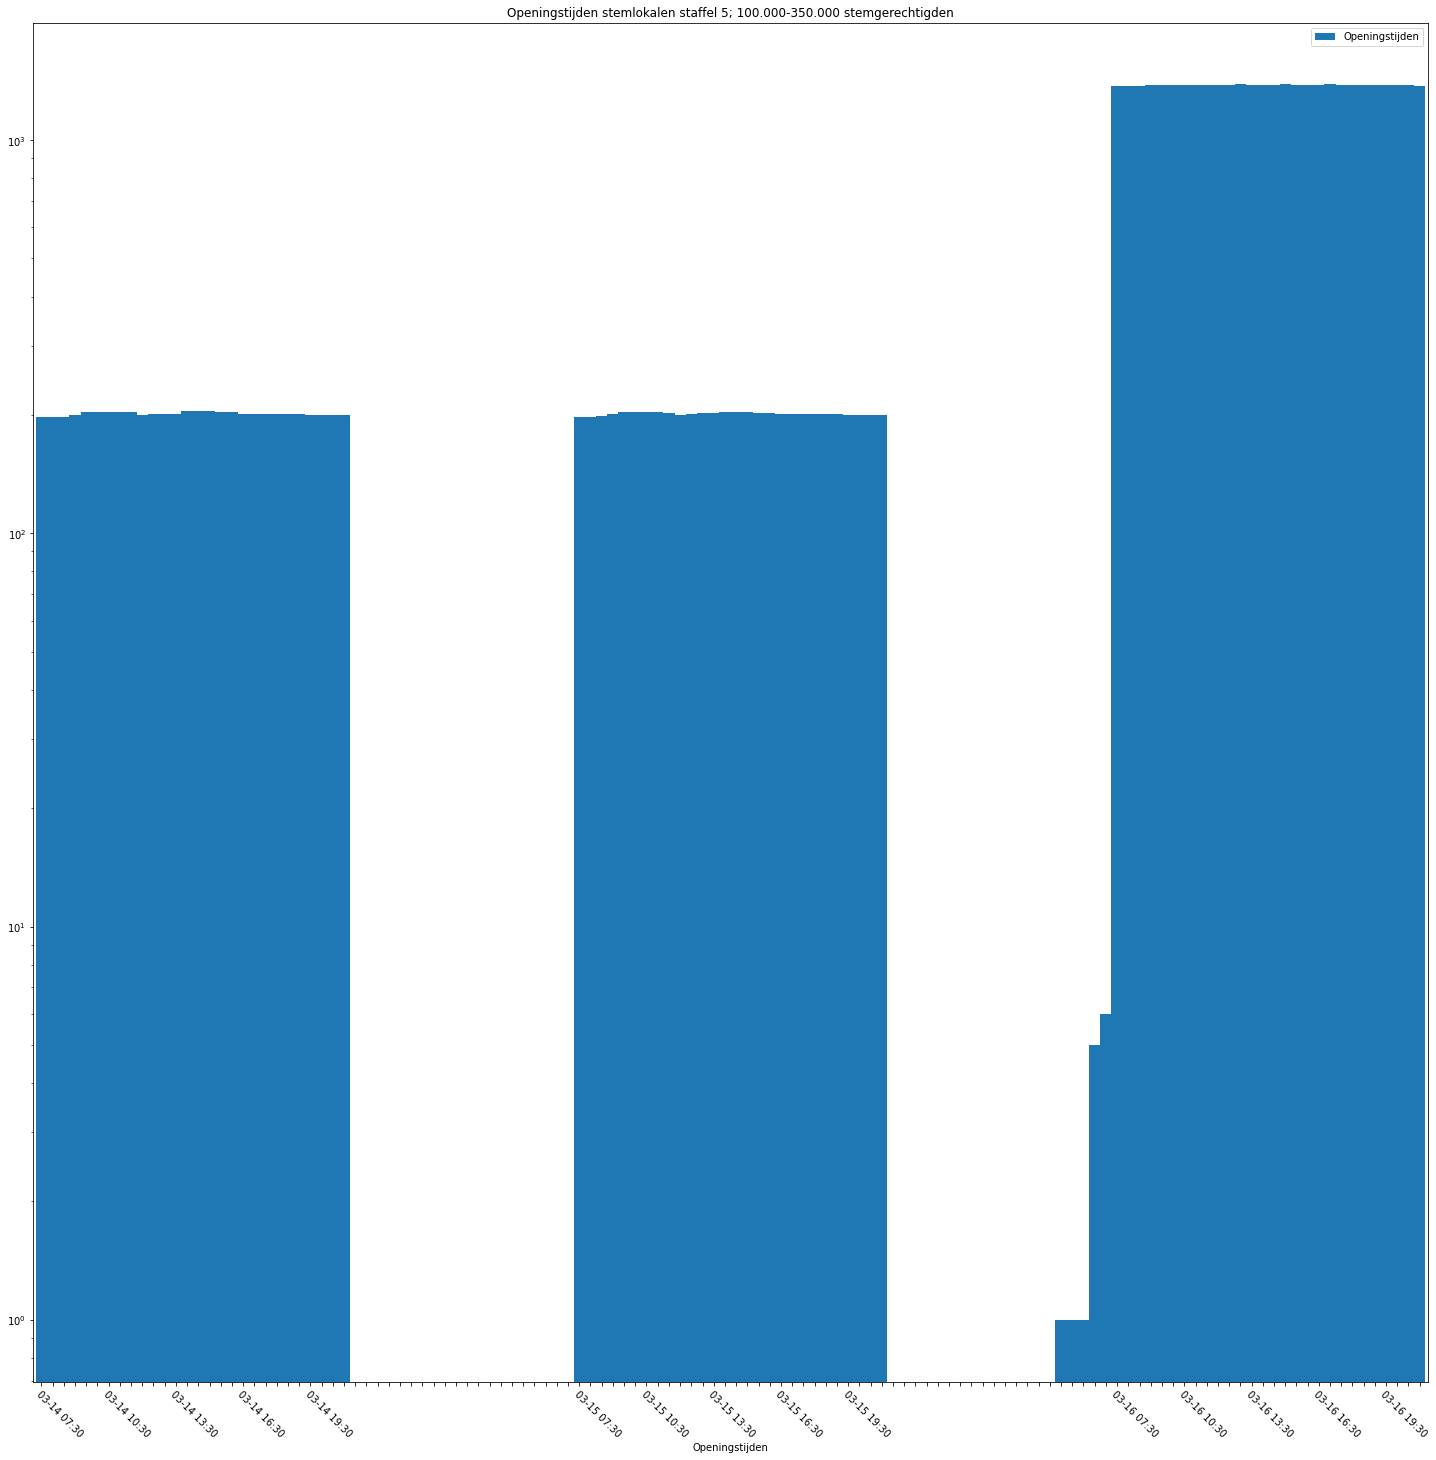

<Figure size 936x936 with 0 Axes>

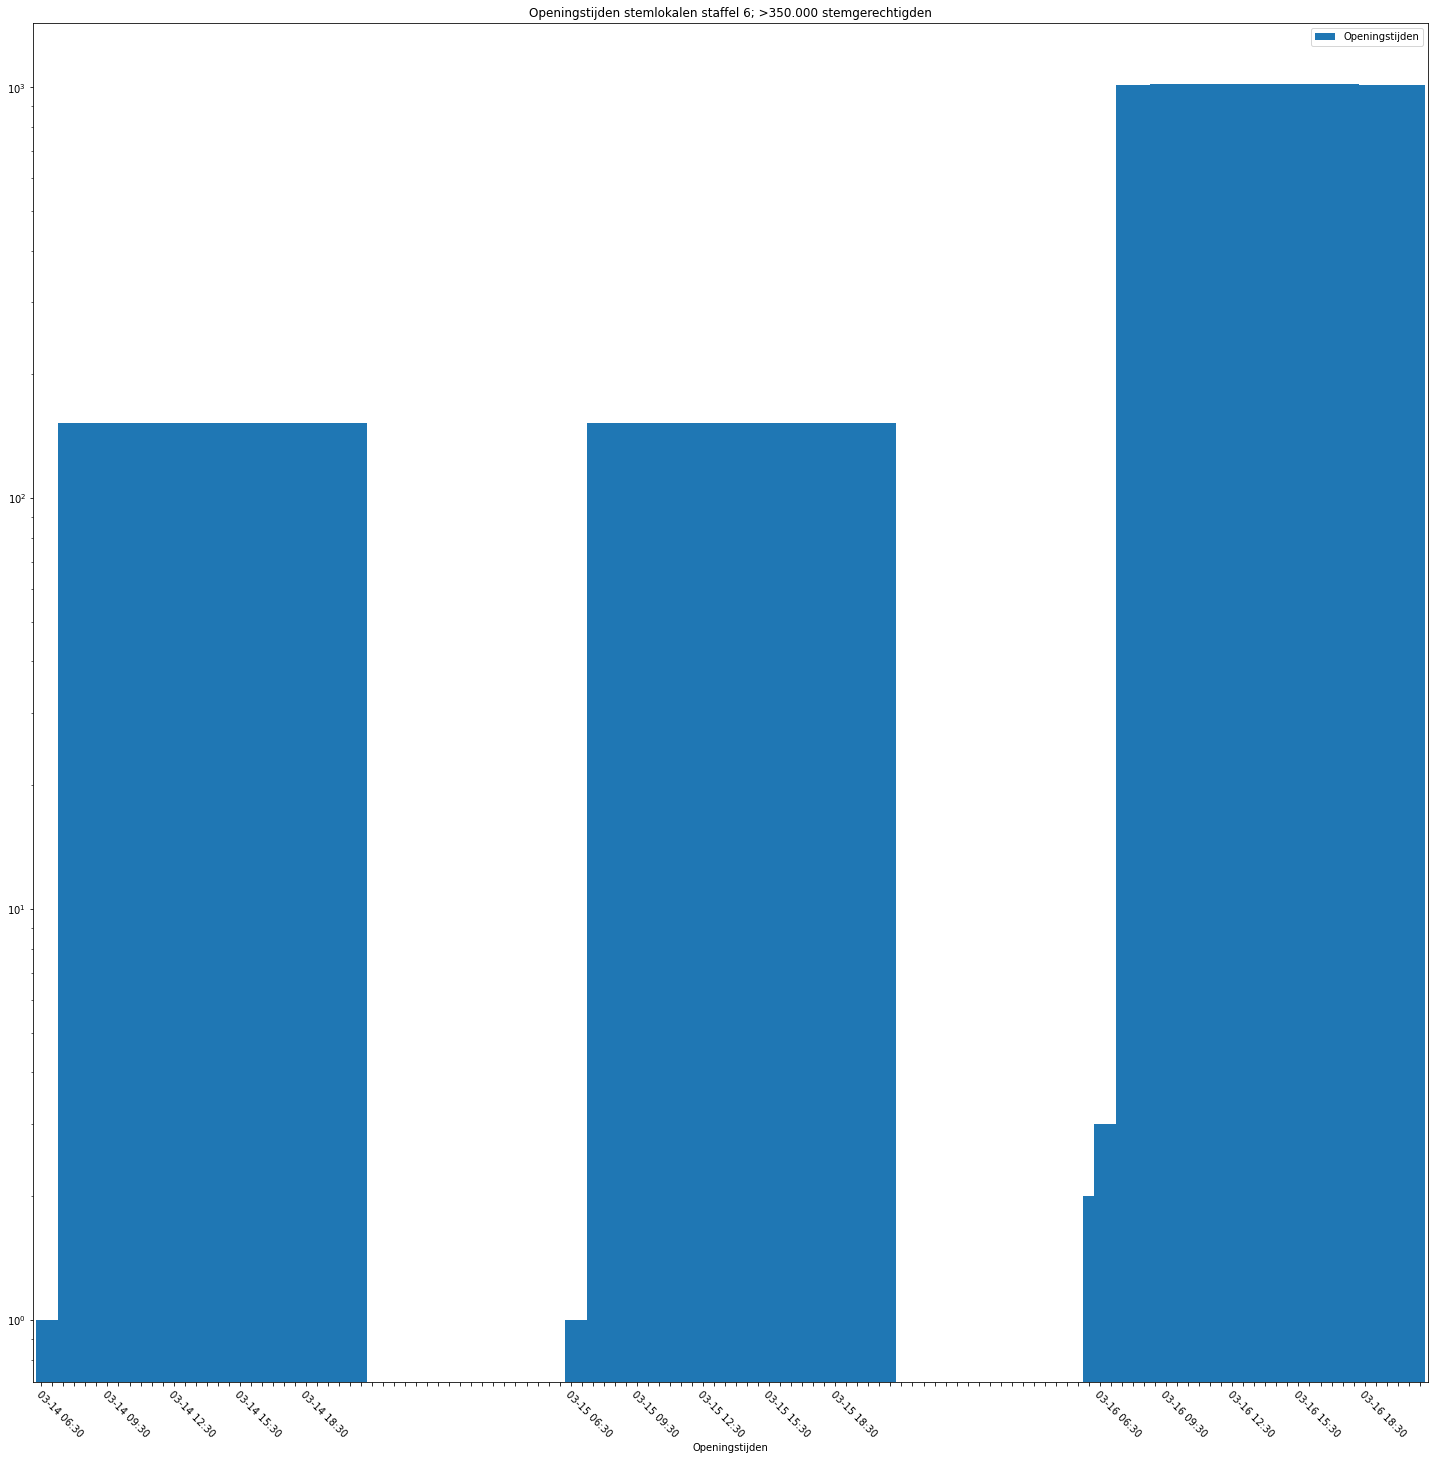

In [42]:
wims_datestack_grouped = pd.DataFrame()
def make_graphs_opening(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    #df_stemger_label.head()
    graph_wims = filter_binned(gdf_wims_dedupe, df_stemger_label)
    graph_wims_split = filter_binned(gdf_wims_split, df_stemger_label)
    plot_opening(graph_wims_split, label)
    
    
for label in labels:
    make_graphs_opening(label)

print(wims_datestack_grouped)

In [43]:
wims_datestack_grouped.drop('Openingstijden', axis=1, inplace=True)
wims_datestack_grouped.reset_index(inplace=True)


In [44]:
def graph_open_stacked(df):
    wims_pivot = df.pivot_table(index='Openingstijden', columns='Staffel', values='UUID', aggfunc='sum')

    ax_open_opening = wims_pivot.plot(kind="bar", stacked=True, fontsize=22, figsize=(40,40), log=True)


    xticks = pd.date_range(start=df.Openingstijden.min(), end=df.Openingstijden.max(), freq="30min")
    xticklabels = []
    tickcount = 0
    for tick in xticks:
        if (tickcount % 6 == 0):
            xticklabels.append(tick.strftime("%d-%m %H:%M"))
        else:
            xticklabels.append(" ")
        tickcount += 1


    ax_open_opening.set_xticklabels(xticklabels, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")


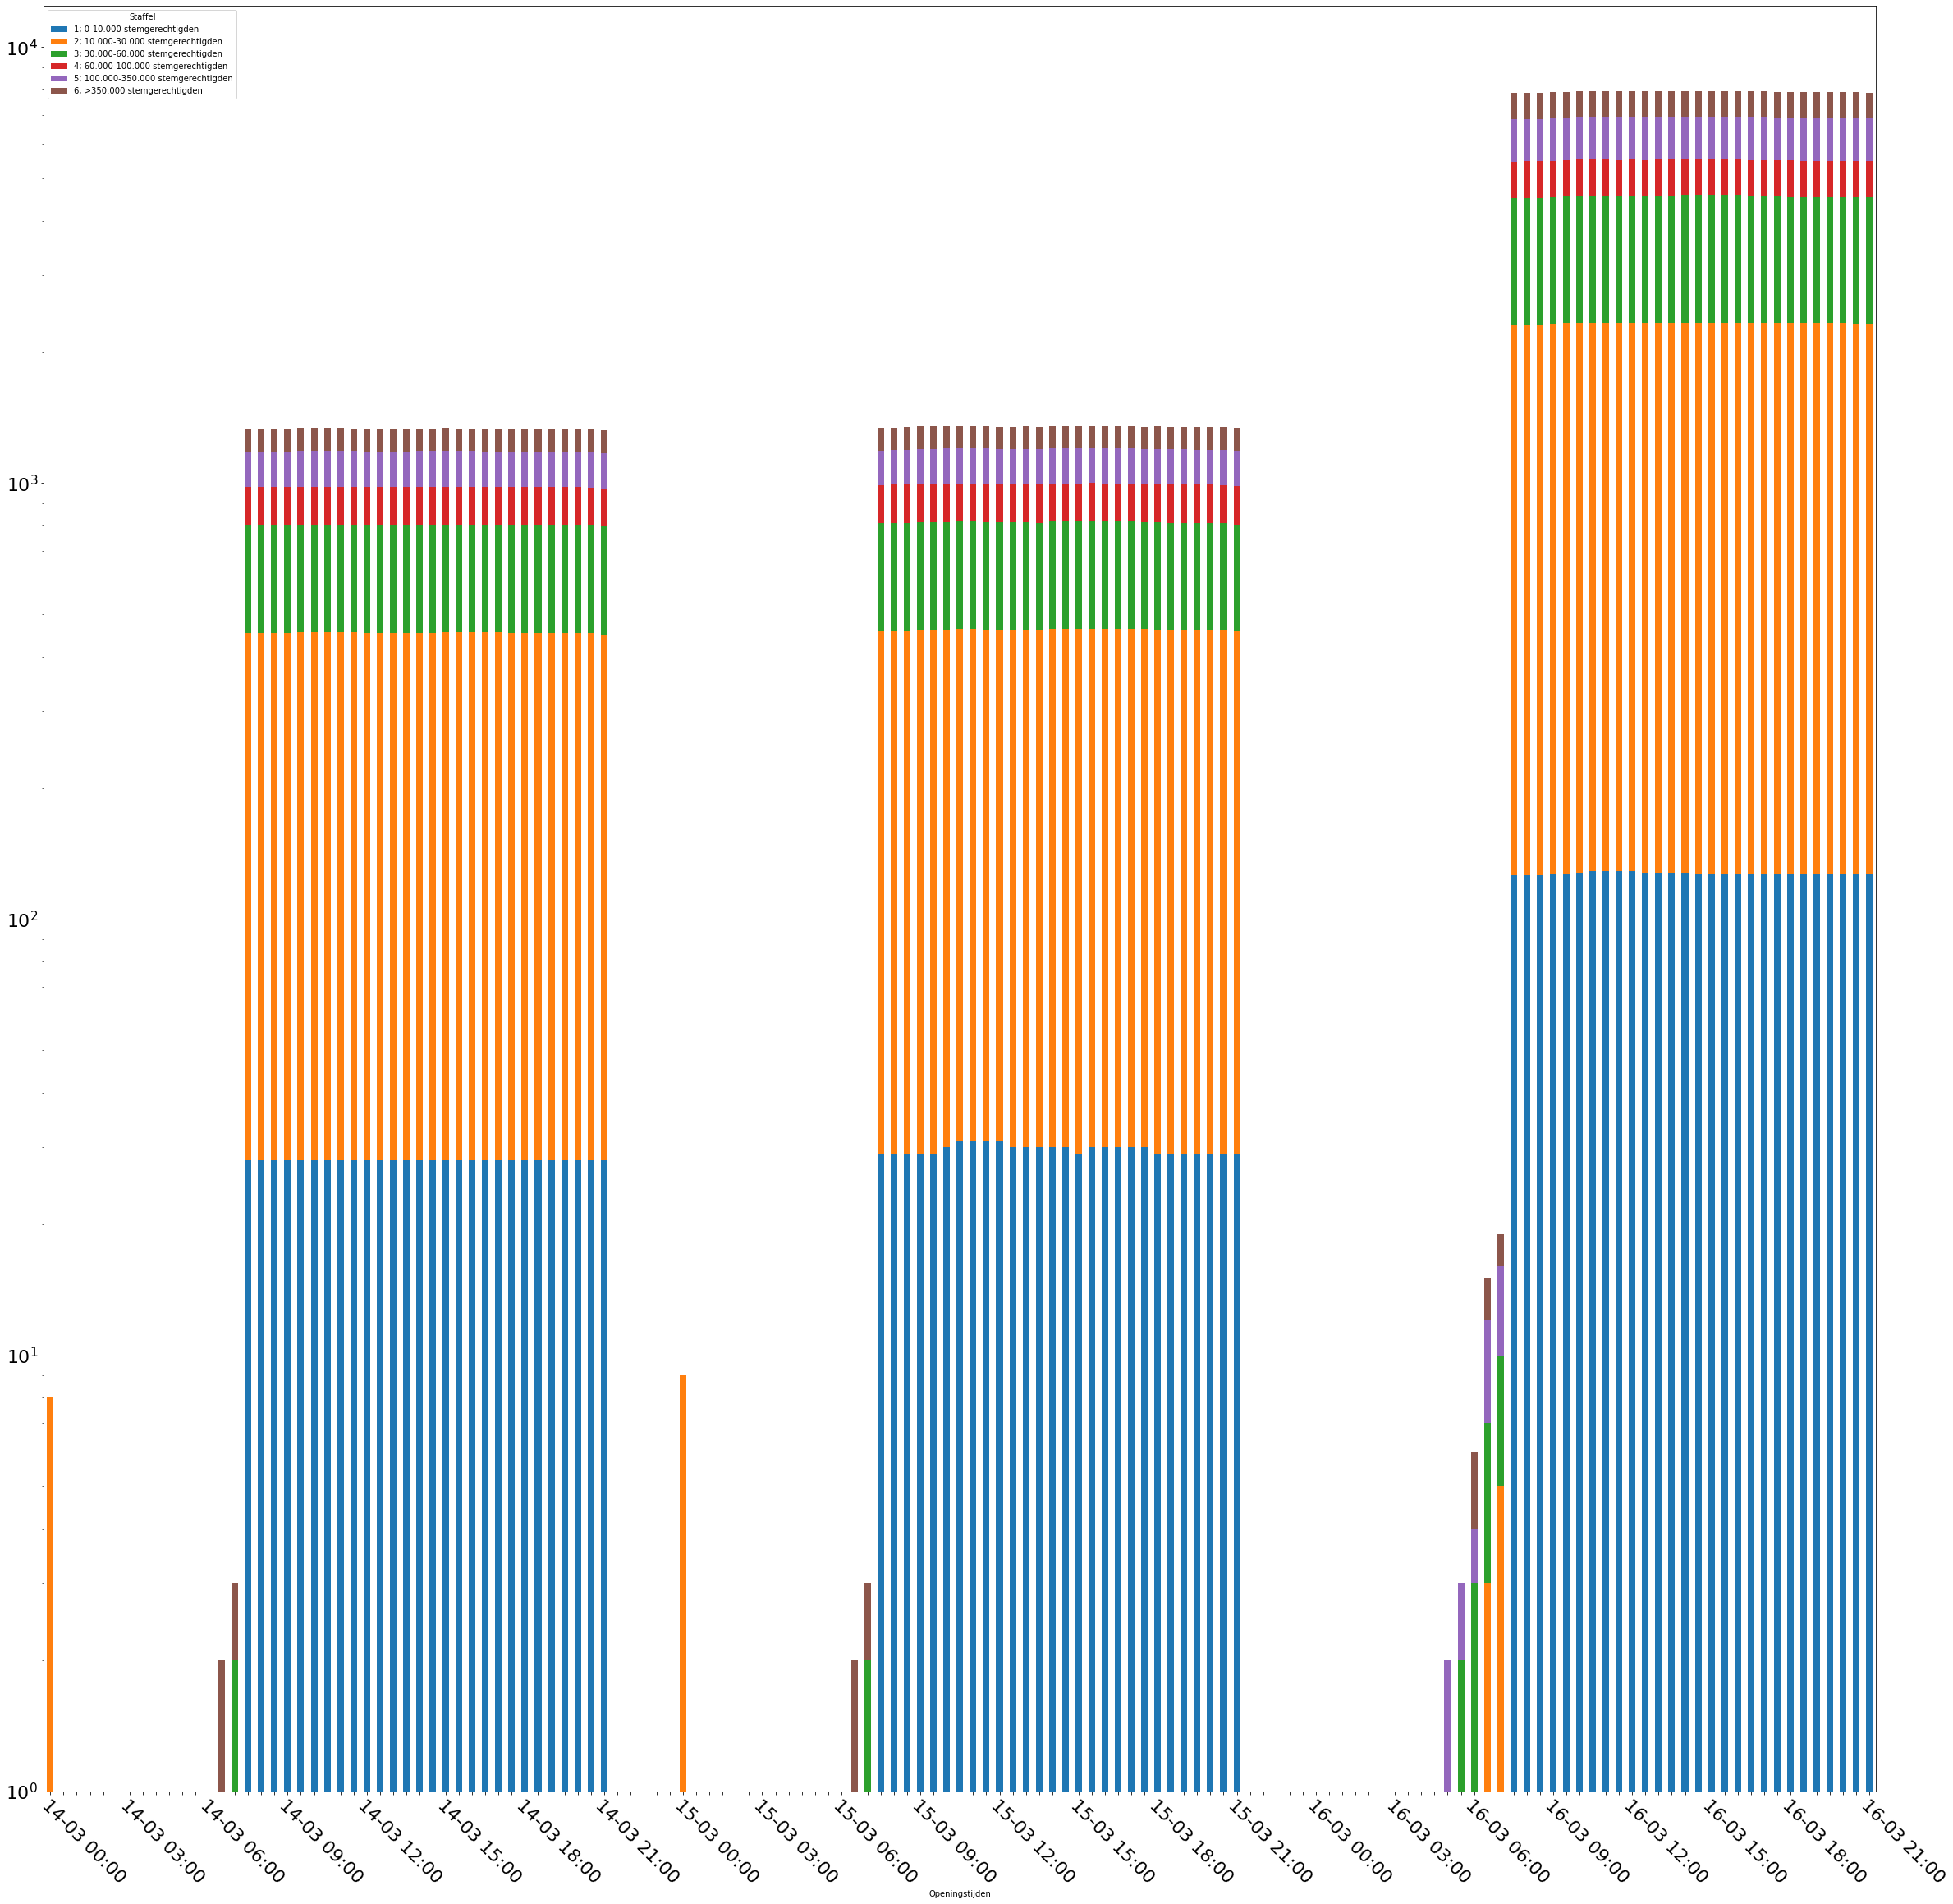

In [45]:
graph_open_stacked(wims_datestack_grouped)

In [46]:
filtered_datestack_1 = wims_datestack_grouped.loc[(pd.to_datetime(wims_datestack_grouped['Openingstijden']) >= pd.to_datetime('2022-03-14T07:30:00.000Z'))
                     & (pd.to_datetime(wims_datestack_grouped['Openingstijden']) <= pd.to_datetime('2022-03-14T21:00:00.000Z'))]
graph_open_stacked(filtered_datestack_1)
"""
filtered_datestack_2 = wims_datestack_grouped.loc[(pd.to_datetime(((wims_datestack_grouped['Openingstijden'])) >= pd.to_datetime('2022-03-15T07:30:00.000Z')))
                     & (pd.to_datetime(wims_datestack_grouped['Openingstijden']) <= pd.to_datetime('2022-03-15T21:00:00.000Z'))]
graph_open_stacked(filtered_datestack_2)
filtered_datestack_3 = wims_datestack_grouped.loc[(pd.to_datetime(wims_datestack_grouped['Openingstijden']) >= pd.to_datetime('2022-03-16T07:30:00.000Z'))
                     & (pd.to_datetime(wims_datestack_grouped['Openingstijden']) <= pd.to_datetime('2022-03-16T21:00:00.000Z'))]
graph_open_stacked(filtered_datestack_3)
"""

TypeError: Invalid comparison between dtype=datetime64[ns] and Timestamp

Staffel: 1; 0-10.000 stemgerechtigden
bijeenkomstfunctie         82
kantoorfunctie             23
sportfunctie               22
woonfunctie                15
overige gebruiksfunctie    12
onderwijsfunctie           10
gezondheidszorgfunctie      6
winkelfunctie               3
industriefunctie            1
Name: Gebruiksdoel van het gebouw, dtype: int64
Staffel: 2; 10.000-30.000 stemgerechtigden
bijeenkomstfunctie         1369
sportfunctie                415
kantoorfunctie              259
onderwijsfunctie            243
woonfunctie                 211
overige gebruiksfunctie      89
gezondheidszorgfunctie       78
industriefunctie             38
winkelfunctie                36
logiesfunctie                33
Name: Gebruiksdoel van het gebouw, dtype: int64
Staffel: 3; 30.000-60.000 stemgerechtigden
bijeenkomstfunctie         1414
sportfunctie                384
onderwijsfunctie            268
kantoorfunctie              203
woonfunctie                 181
overige gebruiksfunctie     10

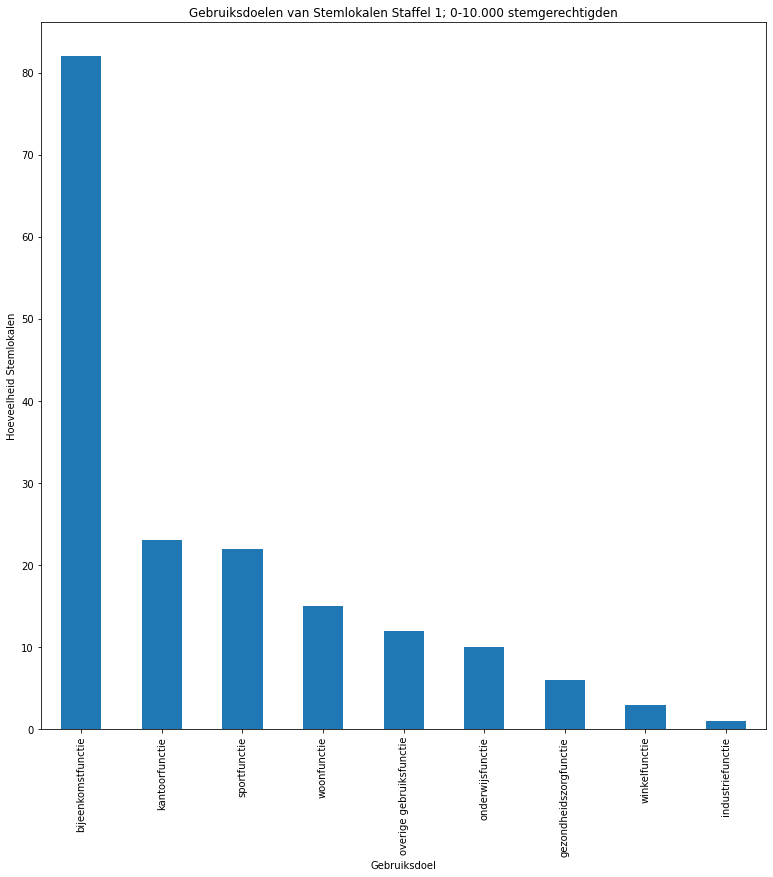

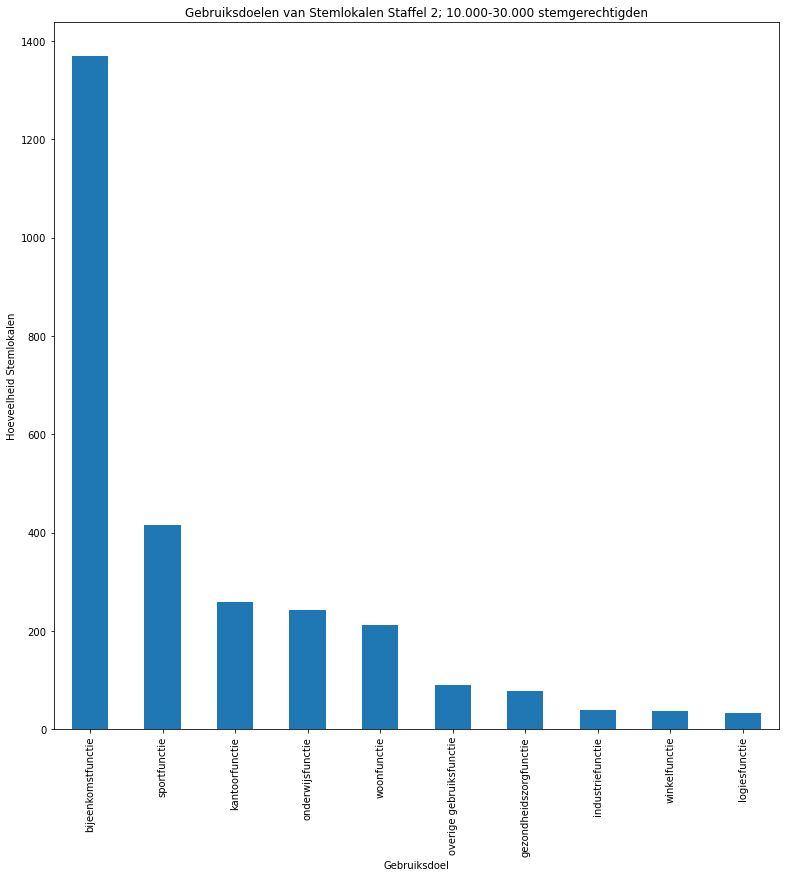

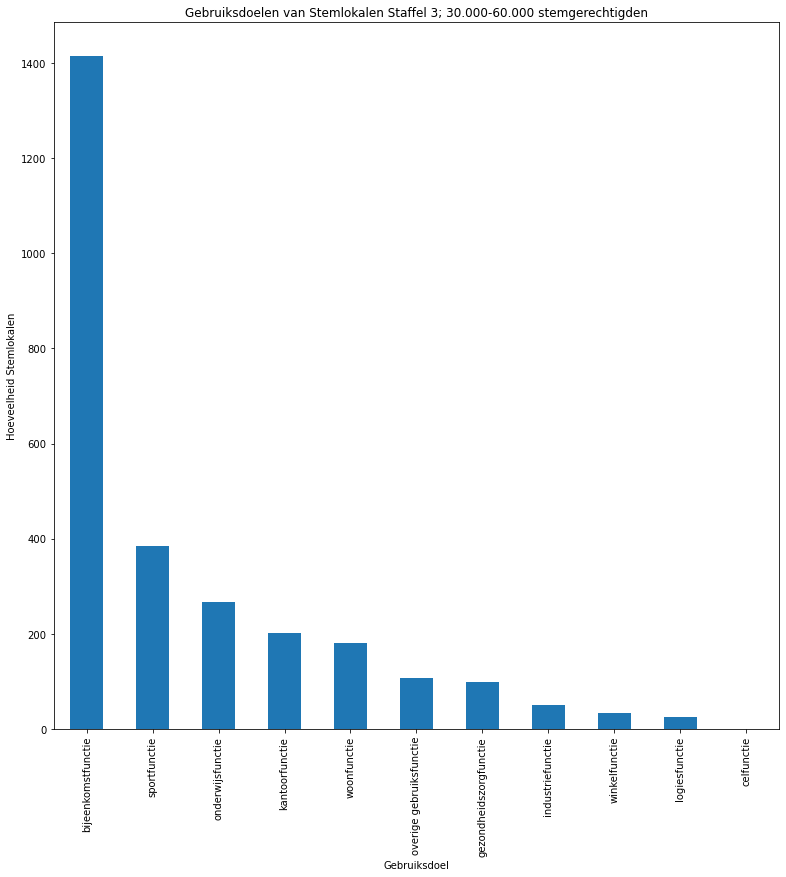

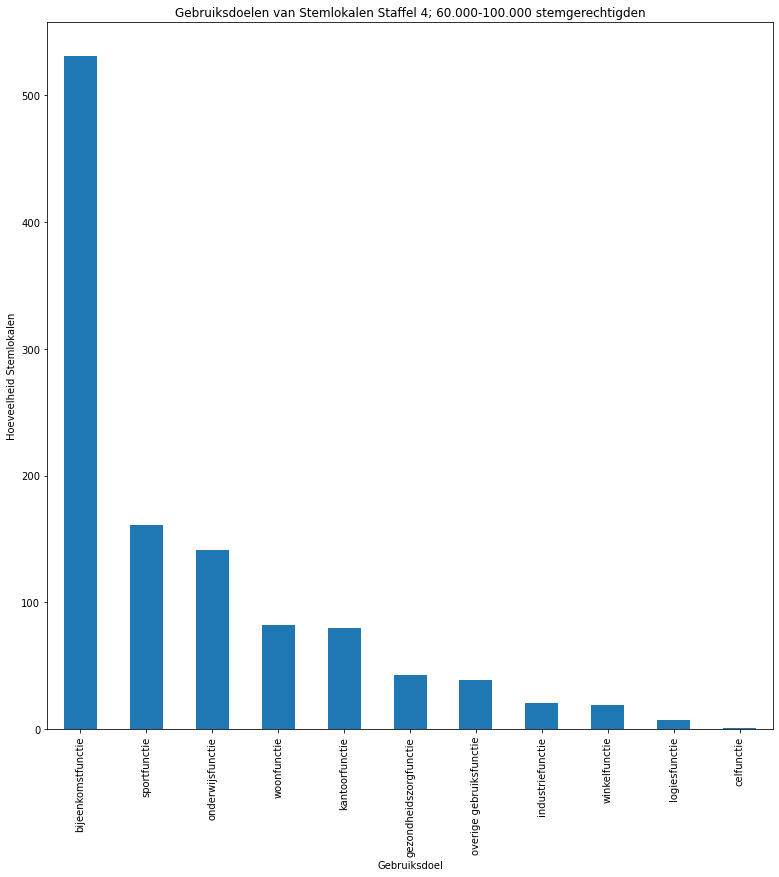

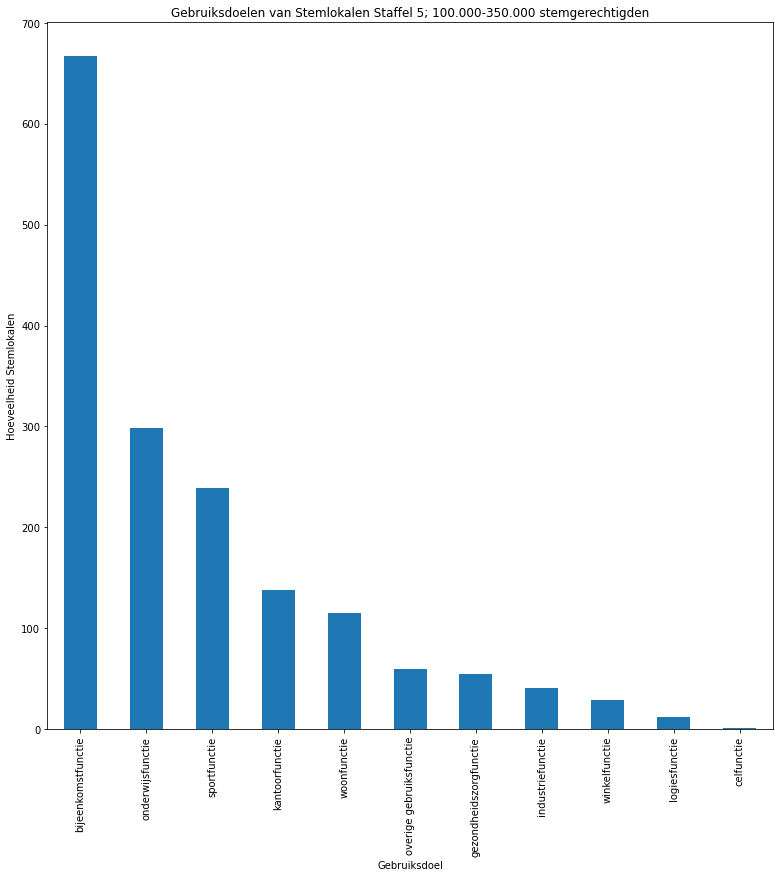

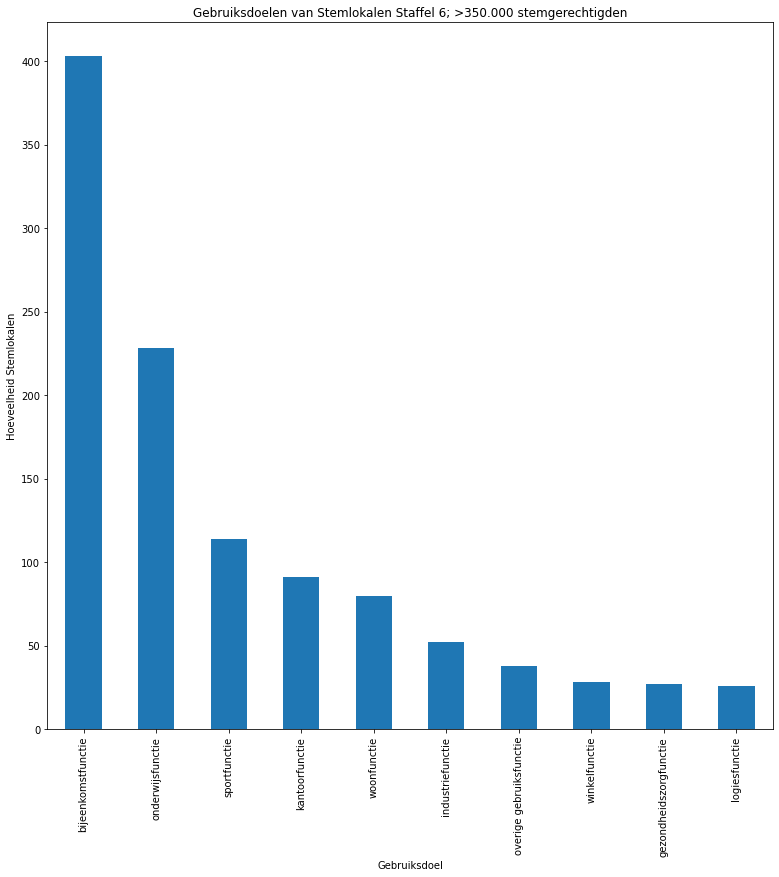

In [60]:
def make_graphs_use(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    plot_use(filter_binned(gdf_wims_dedupe, df_stemger_label), label)

for label in labels:
    make_graphs_use(label)

Open op 14 maart groep totaal: 22
Open op 15 maart groep totaal: 24
Open op 16 maart groep totaal: 6658
Open op 14 én 15 maart groep totaal: 12
Open op 14 én 16 maart groep totaal: 28
Open op 15 én 16 maart groep totaal: 44
Open op 14, 15 én 16 maart groep totaal: 1301
Aantal stemlokalen open op standaard tijden 16 Maart in staffel totaal: 1318


<Figure size 936x936 with 0 Axes>

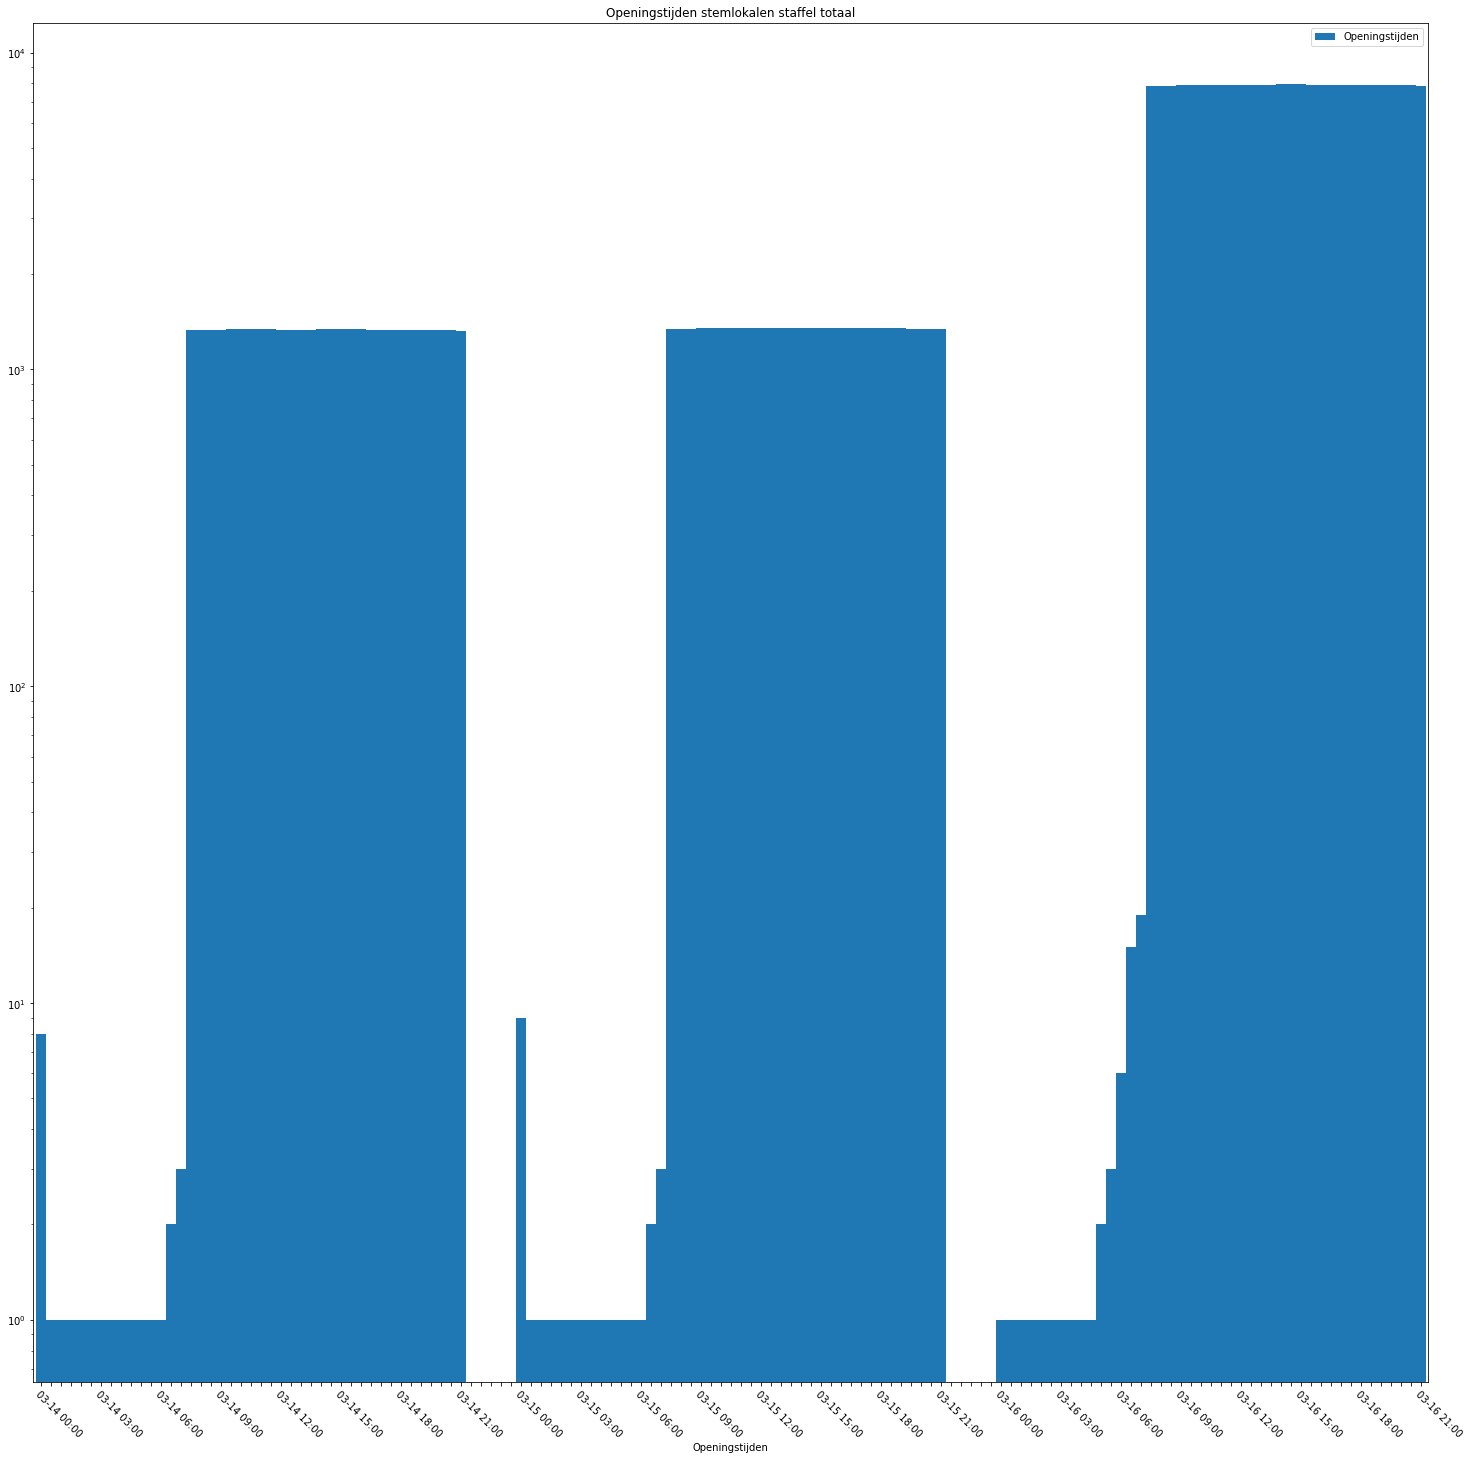

In [61]:
plot_opening(gdf_wims_split, "totaal")

Staffel: totaal
bijeenkomstfunctie         4466
sportfunctie               1335
onderwijsfunctie           1188
kantoorfunctie              794
woonfunctie                 684
overige gebruiksfunctie     346
gezondheidszorgfunctie      309
industriefunctie            204
winkelfunctie               149
logiesfunctie               104
celfunctie                    3
Name: Gebruiksdoel van het gebouw, dtype: int64


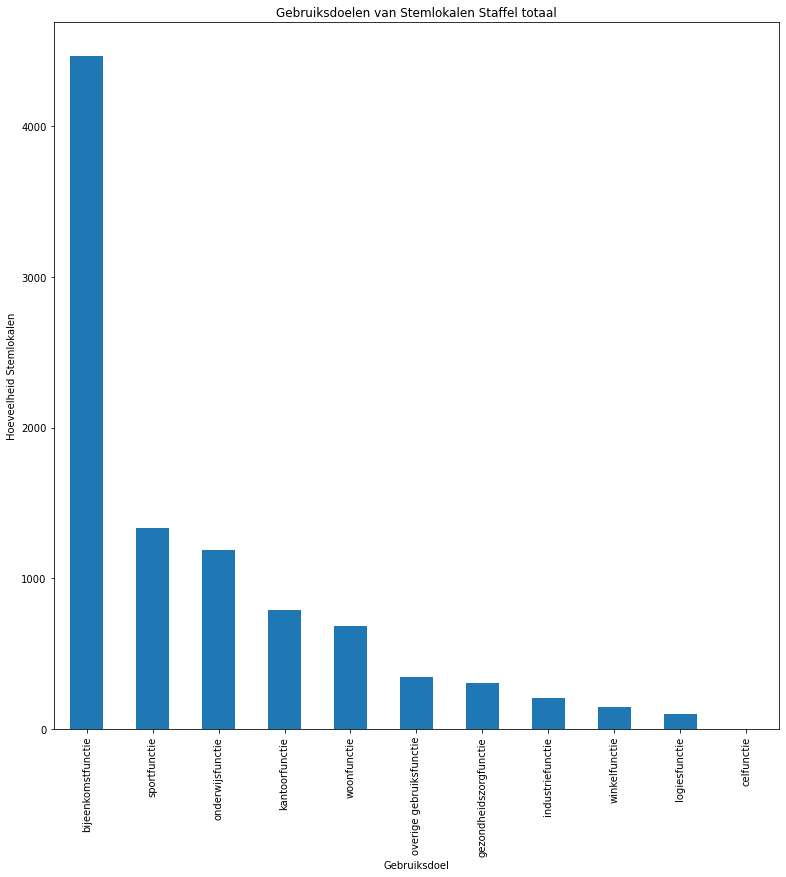

In [62]:
plot_use(gdf_wims_dedupe, "totaal")

In [63]:
 print(df_stemger_clean['binned'].value_counts())

2; 10.000-30.000 stemgerechtigden      170
3; 30.000-60.000 stemgerechtigden       92
1; 0-10.000 stemgerechtigden            25
4; 60.000-100.000 stemgerechtigden      24
5; 100.000-350.000 stemgerechtigden     19
6; >350.000 stemgerechtigden             3
Name: binned, dtype: int64


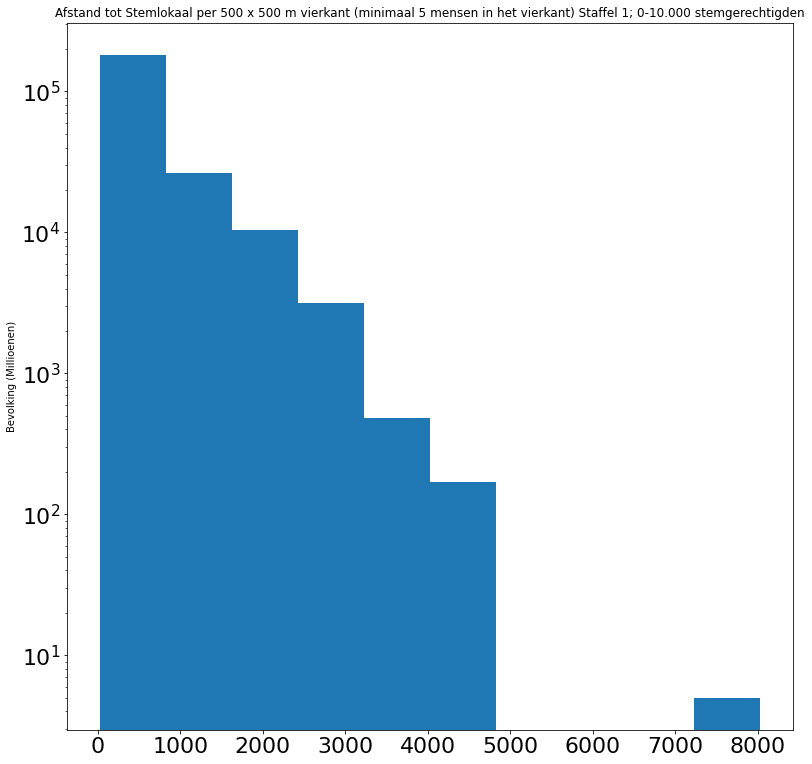

<Figure size 936x936 with 0 Axes>

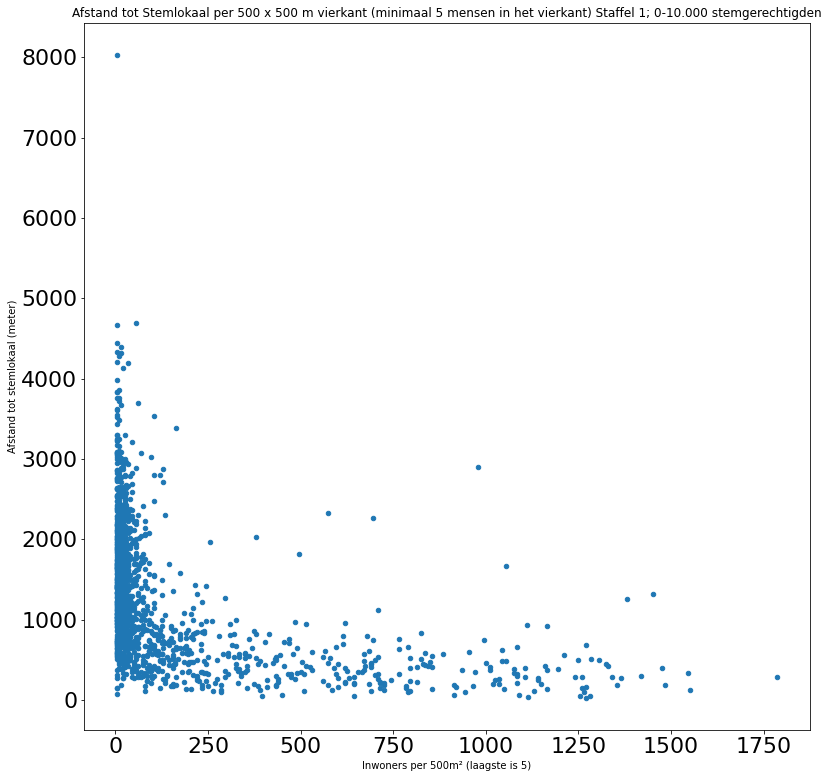

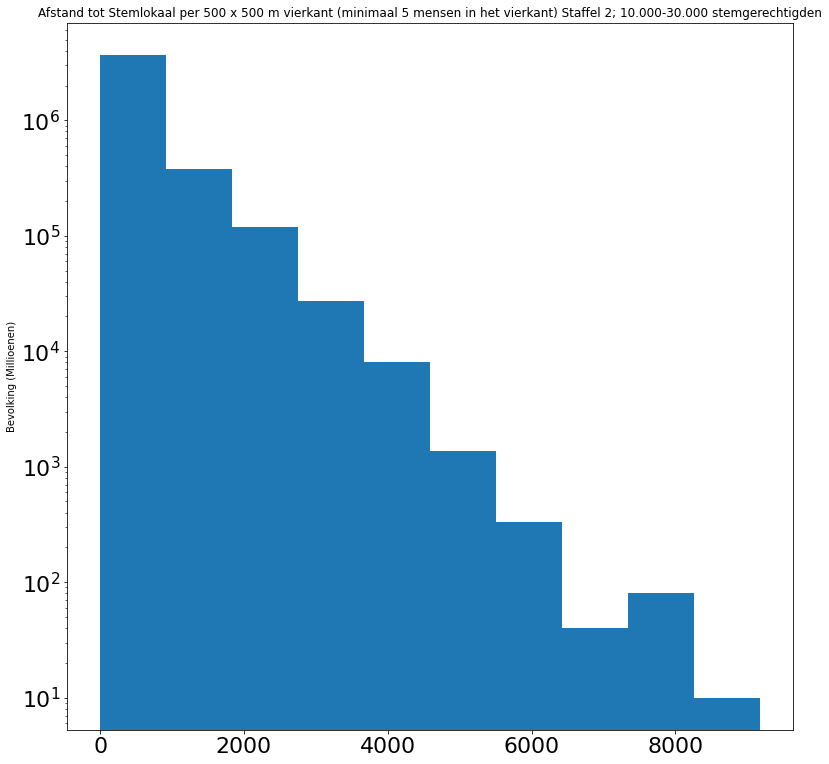

<Figure size 936x936 with 0 Axes>

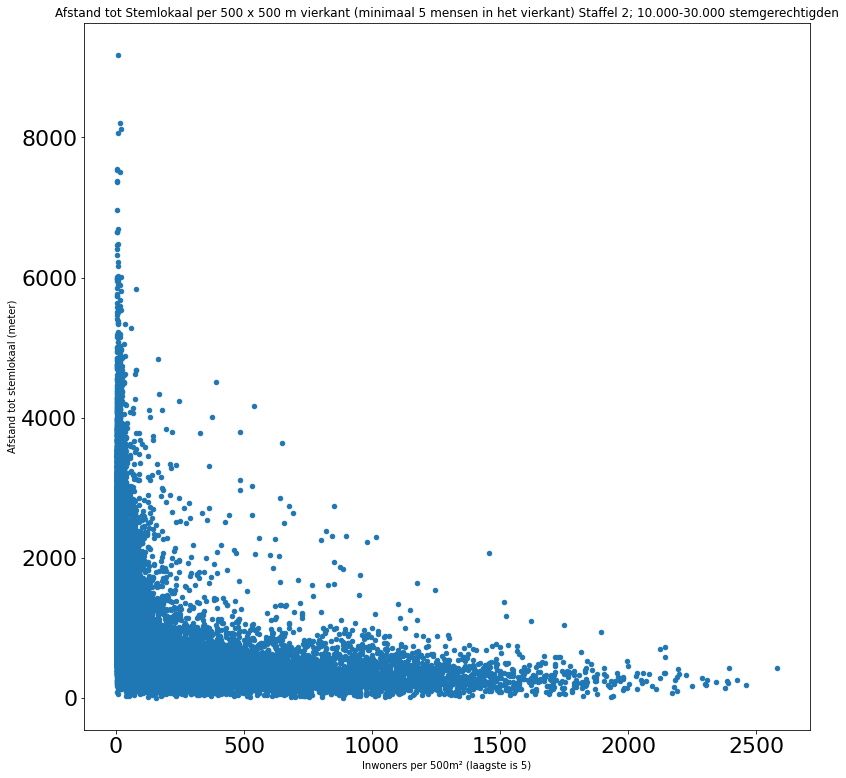

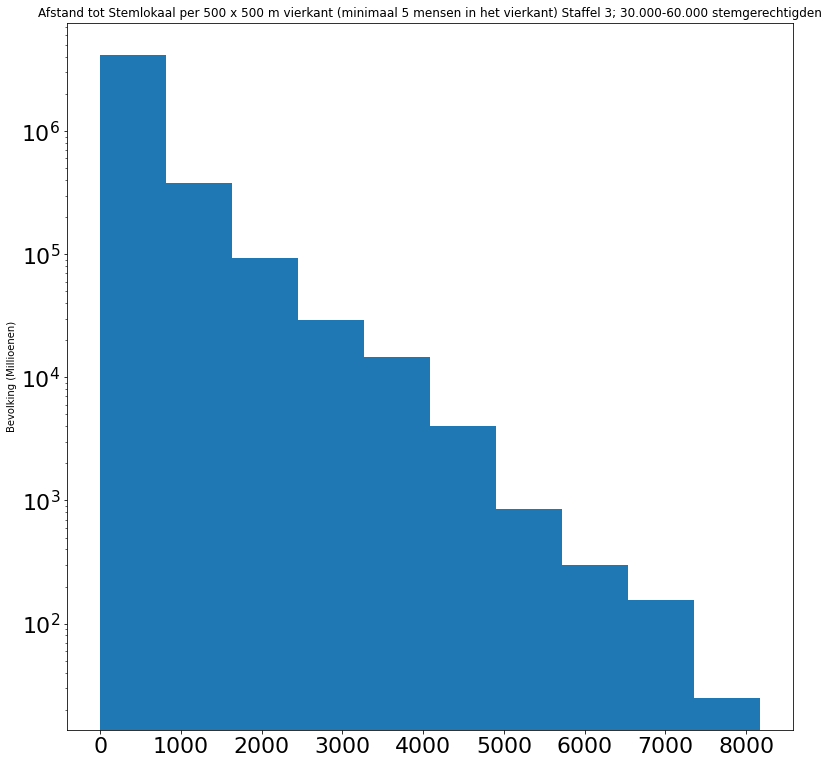

<Figure size 936x936 with 0 Axes>

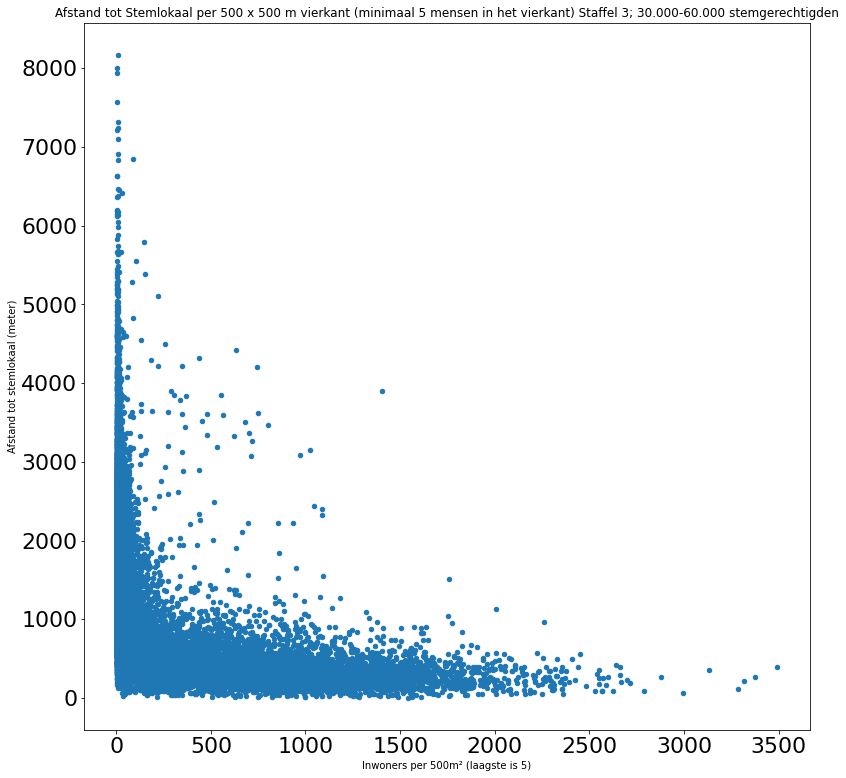

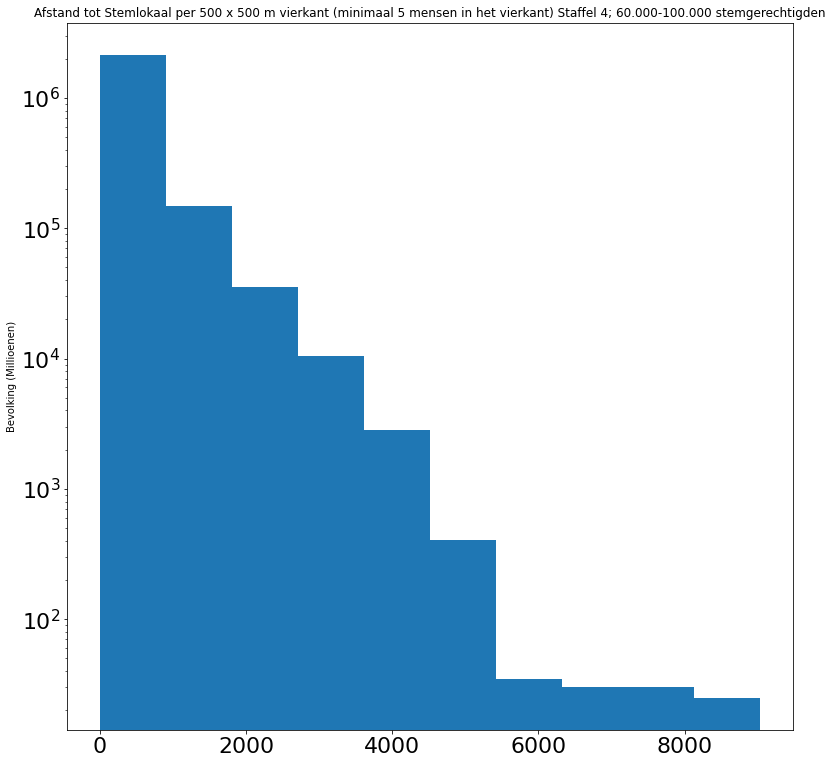

<Figure size 936x936 with 0 Axes>

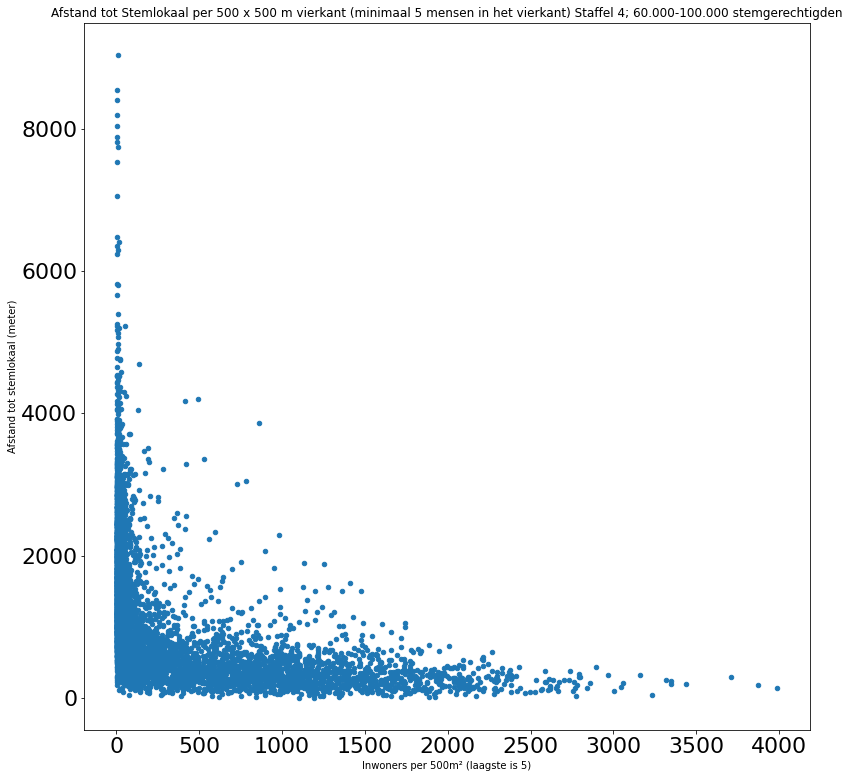

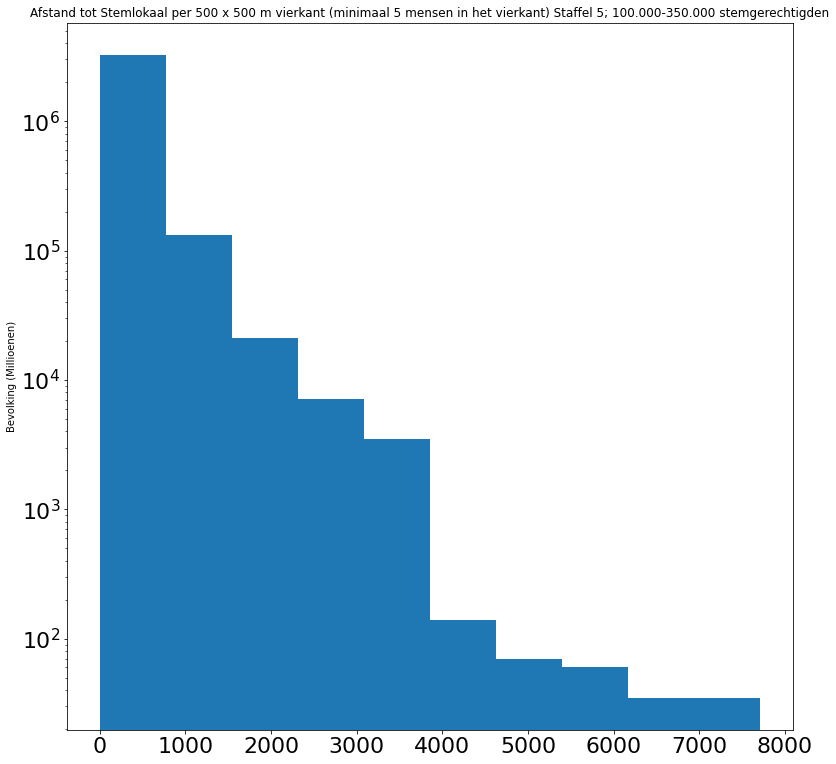

<Figure size 936x936 with 0 Axes>

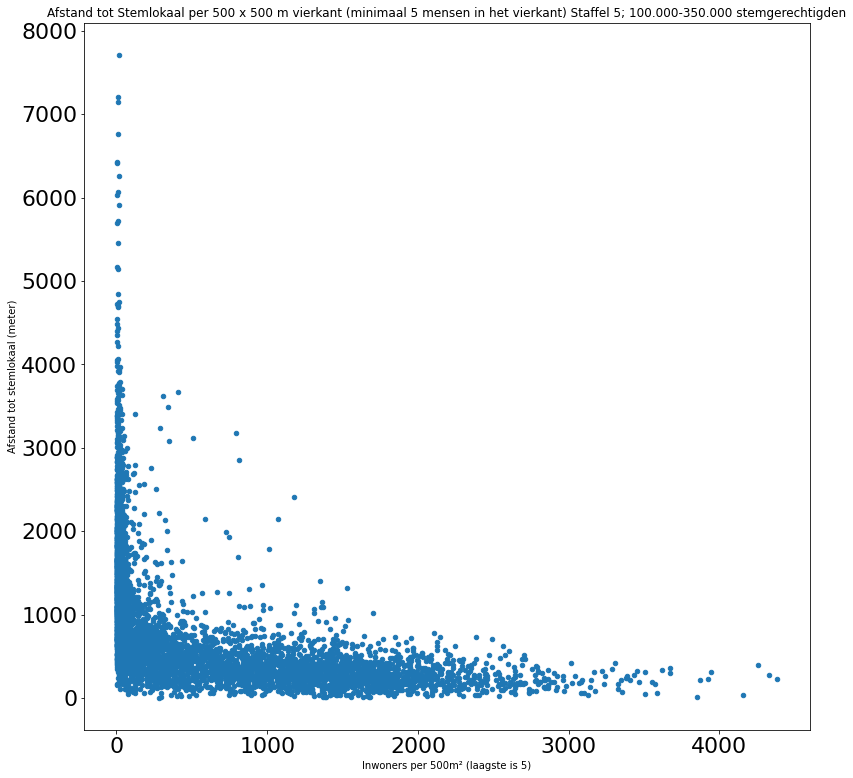

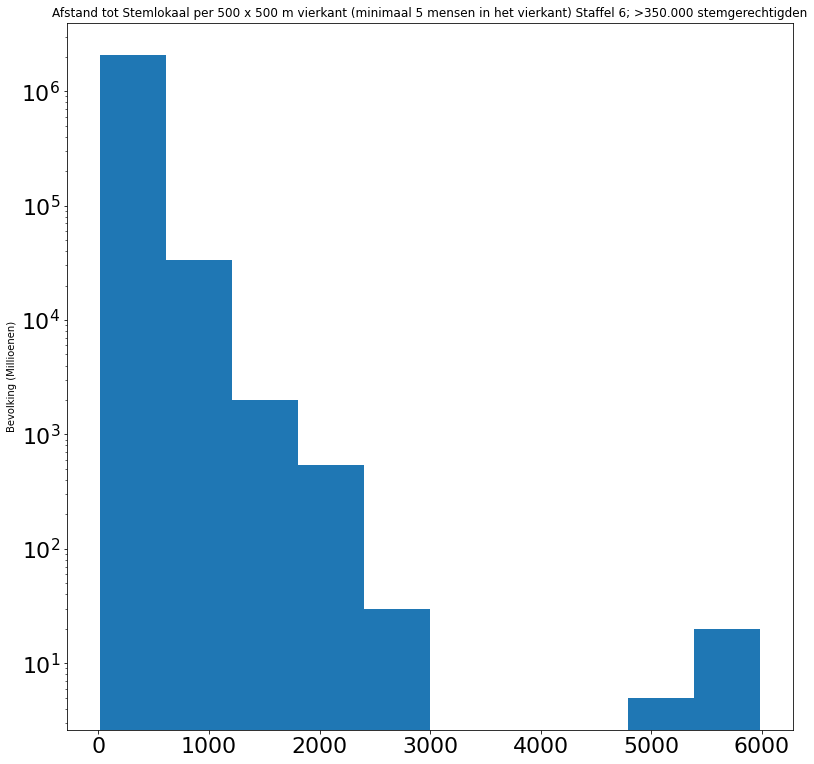

<Figure size 936x936 with 0 Axes>

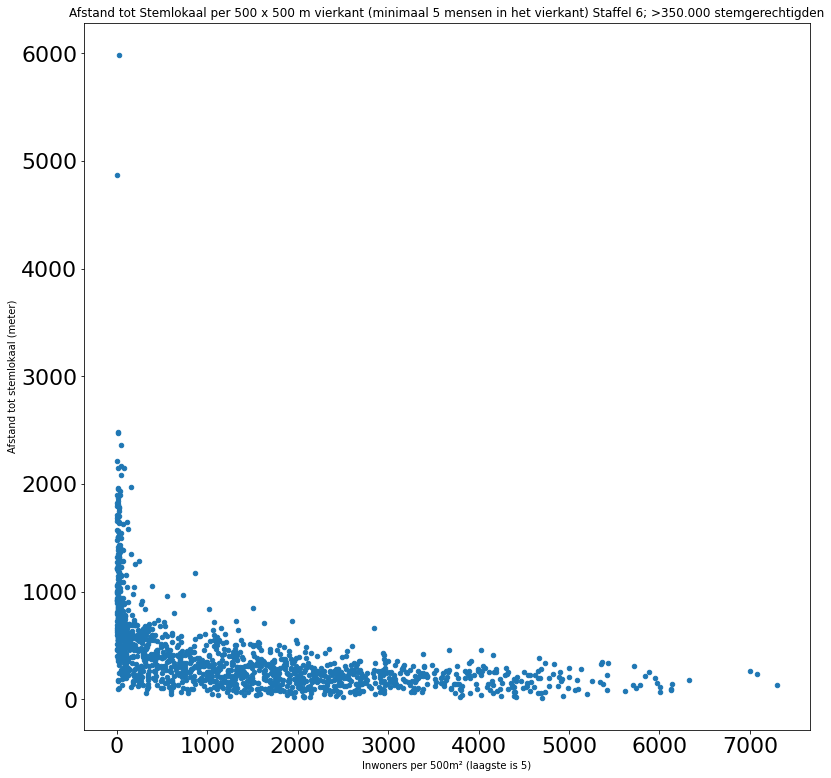

In [64]:
def make_graphs_dist(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    plot_dist(filter_binned(df_nearest, df_stemger_label), label)

for label in labels:
    make_graphs_dist(label)
    

In [65]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()
print("Gemiddelde afstand tot stemlokaal totaal: {}".format(w_avg(df_nearest, "dist", "aantal_inwoners")))

df_nearest_rename = df_nearest.rename(columns = {'CBS gemeentecode': 'gemeentecode'})
print(list(df_nearest_rename))
df_nearest_merged = pd.merge(df_nearest_rename, df_stemger_clean, on=['gemeentecode'])
df_nearest_merged.groupby('binned').apply(w_avg, 'dist', 'aantal_inwoners')

Gemiddelde afstand tot stemlokaal totaal: 434.3908324541042
['crs28992res500m', 'aantal_inwoners', 'stedelijkheid', 'geometry', 'savedindex', 'Unnamed: 0', '_id', 'Gemeente', 'gemeentecode', 'Nummer stembureau', 'Naam stembureau', 'Gebruiksdoel van het gebouw', 'Website locatie', 'Wijknaam', 'CBS wijknummer', 'Buurtnaam', 'CBS buurtnummer', 'BAG Nummeraanduiding ID', 'Straatnaam', 'Huisnummer', 'Huisletter', 'Huisnummertoevoeging', 'Postcode', 'Plaats', 'Extra adresaanduiding', 'X', 'Y', 'Latitude', 'Longitude', 'Openingstijden 14-03-2022', 'Openingstijden 15-03-2022', 'Openingstijden 16-03-2022', 'Toegankelijk voor mensen met een lichamelijke beperking', 'Akoestiek', 'Auditieve hulpmiddelen', 'Visuele hulpmiddelen', 'Gehandicaptentoilet', 'Kieskring ID', 'Hoofdstembureau', 'Tellocatie', 'Contactgegevens gemeente', 'Verkiezingswebsite gemeente', 'Verkiezingen', 'ID', 'UUID', 'dist']


binned
1; 0-10.000 stemgerechtigden           582.737580
2; 10.000-30.000 stemgerechtigden      539.170370
3; 30.000-60.000 stemgerechtigden      472.161641
4; 60.000-100.000 stemgerechtigden     451.049861
5; 100.000-350.000 stemgerechtigden    357.505034
6; >350.000 stemgerechtigden           231.455703
dtype: float64

In [66]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

print(weighted_median(df_nearest_merged, 'dist', 'aantal_inwoners'))

print(df_nearest_merged.groupby('binned').apply(weighted_median, 'dist', 'aantal_inwoners'))

324.59925001723775
binned
1; 0-10.000 stemgerechtigden           420.523944
2; 10.000-30.000 stemgerechtigden      387.837924
3; 30.000-60.000 stemgerechtigden      357.802769
4; 60.000-100.000 stemgerechtigden     338.623546
5; 100.000-350.000 stemgerechtigden    298.937122
6; >350.000 stemgerechtigden           213.189891
dtype: float64


In [67]:
#df_nearest_merged['New']=df_nearest_merged[['aantal_inwoners','r2']].apply(tuple ,1);df_nearest_merged.groupby(['binned']).New.value_counts().reindex(pd.MultiIndex.from_frame(df_nearest_merged[['binned','New']])).values




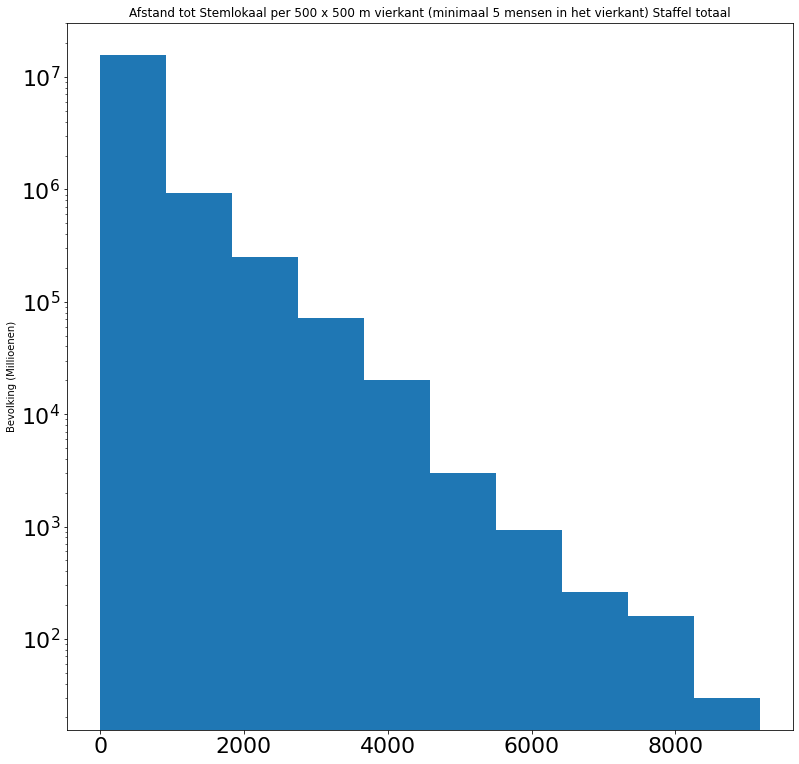

<Figure size 936x936 with 0 Axes>

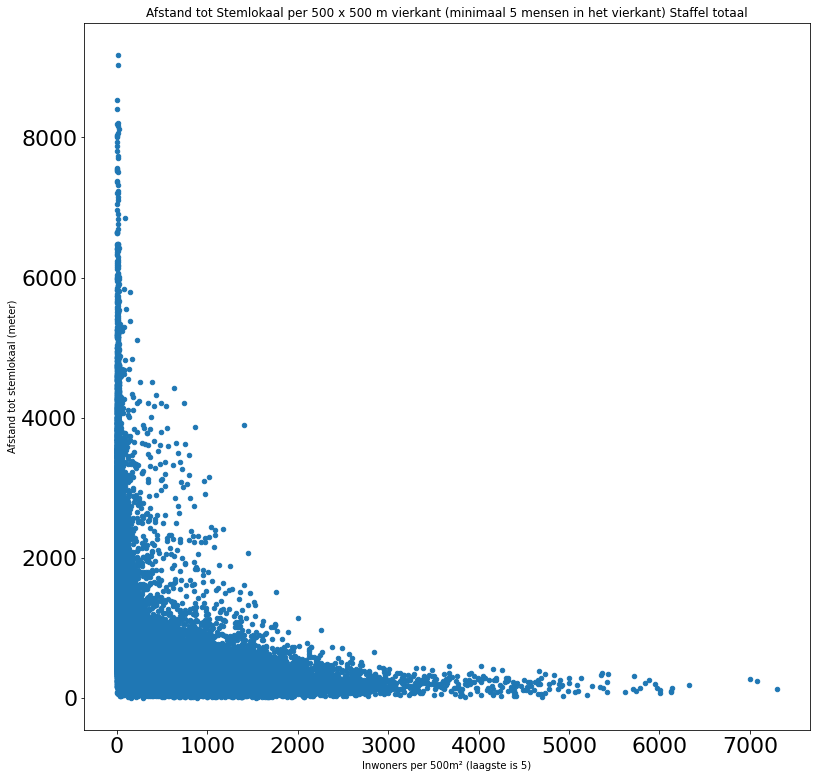

In [68]:
plot_dist(df_nearest, "totaal")

In [69]:
def print_type(df, label):
    print("aantal mobiele stemlokalen groep {}: {}".format(label, df[df["Naam stembureau"].str.contains("Mobiel")]["Naam stembureau"].count()))
    print("aantal drive through stemlokalen groep {}: {}".format(label, df[df["Naam stembureau"].str.contains("Drive")]["Naam stembureau"].count()))
    df_publiek = df.dropna(subset=['Extra adresaanduiding'])
    print("aantal niet publiek open stemlokalen groep {}: {}".format(label, df_publiek[df_publiek["Extra adresaanduiding"].str.contains("Niet open voor algemeen publiek")]["Extra adresaanduiding"].count()))
    print("aantal tent stemlokalen groep {}: {}".format(label, df[df["Naam stembureau"].str.contains("tent")]["Naam stembureau"].count()))
    print("aantal parkeerplaats stemlokalen groep {}: {}".format(label, df[df["Naam stembureau"].str.contains("parkeer")]["Naam stembureau"].count()))
    print("aantal bus stemlokalen groep {}: {}".format(label, df[df["Naam stembureau"].str.contains("bus")]["Naam stembureau"].count()))

In [70]:
print_type(gdf_wims_dedupe, "totaal")
print("\n")

def make_print_type(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    print_type(filter_binned(gdf_wims_dedupe, df_stemger_label), label)

for label in labels: 
    make_print_type(label)
    print("\n")

aantal mobiele stemlokalen groep totaal: 98
aantal drive through stemlokalen groep totaal: 25
aantal niet publiek open stemlokalen groep totaal: 89
aantal tent stemlokalen groep totaal: 13
aantal parkeerplaats stemlokalen groep totaal: 13
aantal bus stemlokalen groep totaal: 23


aantal mobiele stemlokalen groep 1; 0-10.000 stemgerechtigden: 3
aantal drive through stemlokalen groep 1; 0-10.000 stemgerechtigden: 1
aantal niet publiek open stemlokalen groep 1; 0-10.000 stemgerechtigden: 3
aantal tent stemlokalen groep 1; 0-10.000 stemgerechtigden: 0
aantal parkeerplaats stemlokalen groep 1; 0-10.000 stemgerechtigden: 0
aantal bus stemlokalen groep 1; 0-10.000 stemgerechtigden: 0


aantal mobiele stemlokalen groep 2; 10.000-30.000 stemgerechtigden: 30
aantal drive through stemlokalen groep 2; 10.000-30.000 stemgerechtigden: 5
aantal niet publiek open stemlokalen groep 2; 10.000-30.000 stemgerechtigden: 27
aantal tent stemlokalen groep 2; 10.000-30.000 stemgerechtigden: 3
aantal parkeerpla

In [71]:
#print(list(gdf_wims_dedupe))

#print(list(df_stemger_clean))


#gdf_wims_dedupe.rename(columns = {'CBS gemeentecode': 'gemeentecode'}, inplace = True)
#wims_merged = pd.merge(gdf_wims_dedupe, df_stemger_clean, on=['gemeentecode'])
#wims_merged.rename(columns = {'binned': 'staffel'}, inplace = True)
#wims_merged.to_csv(path_or_buf='../data/export/openingstijden_alle_staffels.csv', sep=';', na_rep='', header=True, date_format = '%m-%d %H:%M')

#df_nearest.rename(columns = {'CBS gemeentecode': 'gemeentecode'}, inplace = True)
#df_merged = pd.merge(df_nearest, df_stemger_clean, on=['gemeentecode'])
#df_merged.rename(columns = {'binned': 'staffel'}, inplace = True)
#df_merged.to_csv(path_or_buf='../data/export/afstand_alle_staffels.csv', sep=';', na_rep='', header=True, date_format = '%m-%d %H:%M')

In [72]:
#de eerste vijf rijen zijn meta-data en kunnen we gerust weghalen voor nu 
#df_gr_gr = pd.read_csv(r'../data/stemmen/01_Groningen/#osv4-3_telling_gr2022_groningen.csv', skiprows=5, header=None, delimiter=';')
#print(df_gr_gr)

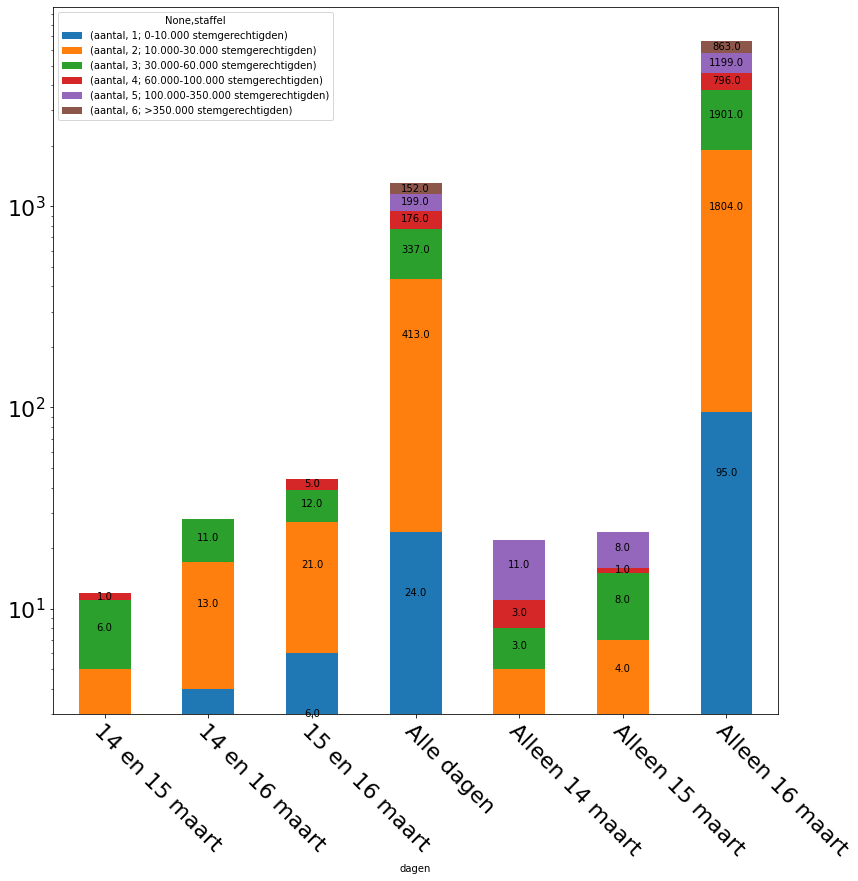

In [73]:
open = {
        'dagen': [],
        'aantal': [],
        'staffel': []
    }


def graph_open_2(df, label):
    
    open['dagen'].append("14 en 15 maart")
    open['aantal'].append(df[df['Openingstijden 16-03-2022 van'].isnull()].dropna(subset=['Openingstijden 15-03-2022 van'])['Openingstijden 14-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("14 en 16 maart")
    open['aantal'].append(df[df['Openingstijden 15-03-2022 van'].isnull()].dropna(subset=['Openingstijden 16-03-2022 van'])['Openingstijden 14-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("15 en 16 maart")
    open['aantal'].append(df[df['Openingstijden 14-03-2022 van'].isnull()].dropna(subset=['Openingstijden 15-03-2022 van'])['Openingstijden 16-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("Alle dagen")
    open['aantal'].append(df.dropna(subset=['Openingstijden 16-03-2022 van', 'Openingstijden 15-03-2022 van'])['Openingstijden 14-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("Alleen 14 maart")
    open['aantal'].append(df[df['Openingstijden 15-03-2022 van'].isnull()][df['Openingstijden 16-03-2022 van'].isnull()]['Openingstijden 14-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("Alleen 15 maart")
    open['aantal'].append(df[df['Openingstijden 14-03-2022 van'].isnull()][df['Openingstijden 16-03-2022 van'].isnull()]['Openingstijden 15-03-2022 van'].count())
    open['staffel'].append(label)

    open['dagen'].append("Alleen 16 maart")
    open['aantal'].append(df[df['Openingstijden 14-03-2022 van'].isnull()][df['Openingstijden 15-03-2022 van'].isnull()]['Openingstijden 16-03-2022 van'].count())
    open['staffel'].append(label)


def make_graph_open_2(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    graph_open_2(filter_binned(gdf_wims_times, df_stemger_label), label)

for label in labels: 
    make_graph_open_2(label)

dagen = sorted(list(dict.fromkeys(open['dagen'])))

df_open_dagen = pd.DataFrame(open).pivot(index='dagen', columns=['staffel'], values=['aantal'])

#ax_open = pd.DataFrame(open).pivot(index='dagen', columns=['staffel'], values=['aantal']).plot(kind="bar", stacked=True, figsize=(13,13), fontsize=22)

#ax_open.set_xticklabels(dagen, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")

#for c in ax_open.containers:

    # Optional: if the segment is small or 0, customize the labels
    #labels_ax= [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    #ax_open.bar_label(c, labels=labels_ax, label_type='center')

ax_open_log = pd.DataFrame(open).pivot(index='dagen', columns=['staffel'], values=['aantal']).plot(kind="bar", stacked=True, fontsize=22, figsize=(13,13), log=True)

ax_open_log.set_xticklabels(dagen, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")

for c in ax_open_log.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels_ax = [v.get_height() for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax_open_log.bar_label(c, labels=labels_ax, label_type='center', padding = 0)

#pd.DataFrame(open).pivot(index='dagen', columns=['staffel'], values=['aantal']).plot(kind="bar", stacked=True, figsize=(13,13))

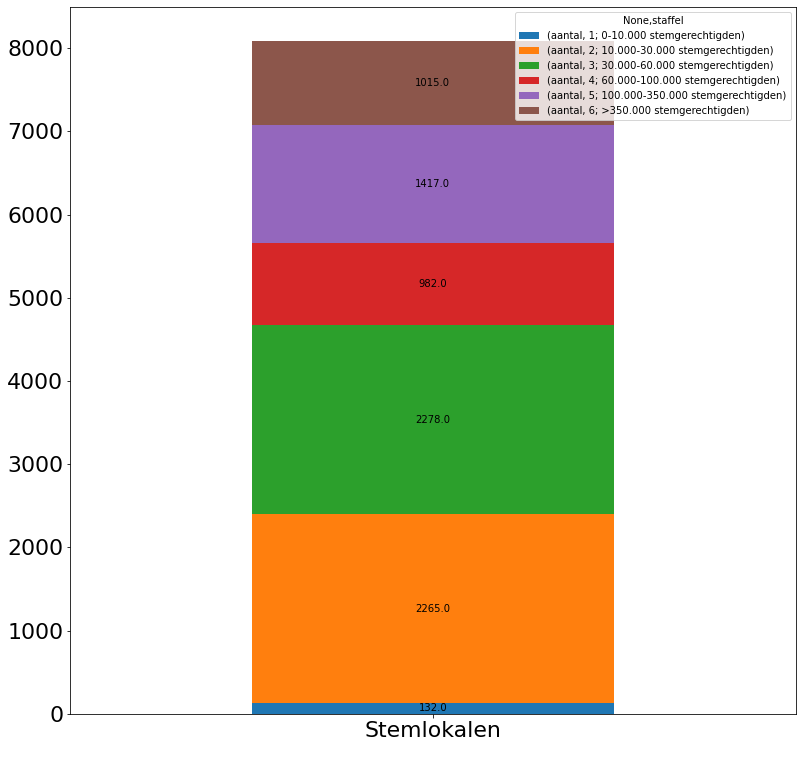

In [74]:
amount = {
        ' ': [],
        'aantal': [],
        'staffel': []
    }

def graph_count(df, label):
    amount[' '].append("Stemlokaal")
    amount['aantal'].append(df["UUID"].count())
    amount['staffel'].append(label)

def make_graph_count(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    graph_count(filter_binned(gdf_wims_dedupe, df_stemger_label), label)

for label in labels: 
    make_graph_count(label)



ax_stemlok = pd.DataFrame(amount).pivot(index=' ', columns=['staffel'], values=['aantal']).plot(kind="bar", stacked=True, figsize=(13,13), fontsize=22)

ax_stemlok.set_xticklabels(['Stemlokalen'], fontsize=22, rotation=0, ha="center", rotation_mode="anchor")

for c in ax_stemlok.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels_ax = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax_stemlok.bar_label(c, labels=labels_ax, label_type='center')


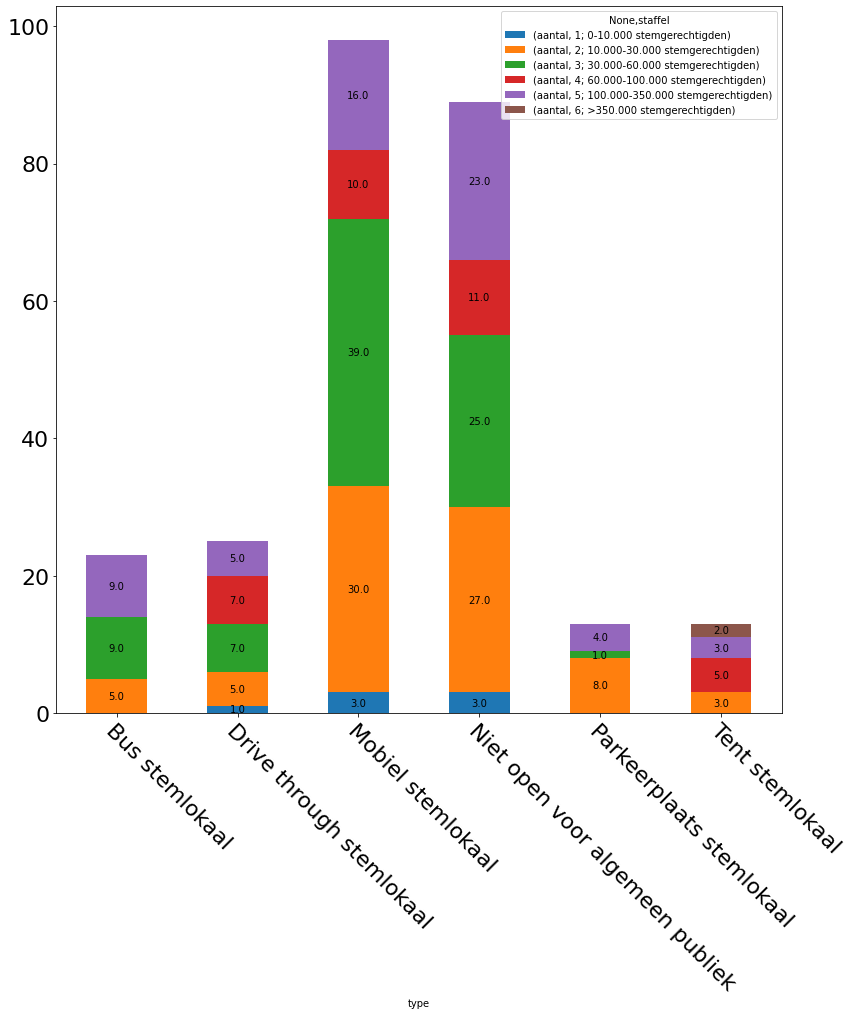

In [75]:
counts =   {'type': [],
                'aantal': [],
                'staffel': []}
def graph_type(df, label):
    
    counts['type'].append("Mobiel stemlokaal") 
    counts['aantal'].append(df[df["Naam stembureau"].str.contains("Mobiel")]["Naam stembureau"].count())
    counts['staffel'].append(label)
    counts['type'].append("Drive-through stemlokaal")
    counts['aantal'].append(df[df["Naam stembureau"].str.contains("Drive")]["Naam stembureau"].count())
    counts['staffel'].append(label)
    df_publiek = df.dropna(subset=['Extra adresaanduiding'])
    counts['type'].append("Niet open algemeen publiek")
    counts['aantal'].append(df_publiek[df_publiek["Extra adresaanduiding"].str.contains("Niet open voor algemeen publiek")]["Extra adresaanduiding"].count())
    counts['staffel'].append(label)
    counts['type'].append("Tent stemlokaal")
    counts['aantal'].append(df[df["Naam stembureau"].str.contains("tent")]["Naam stembureau"].count())
    counts['staffel'].append(label)
    counts['type'].append("Parkeerplaats stemlokaal")
    counts['aantal'].append(df[df["Naam stembureau"].str.contains("parkeer")]["Naam stembureau"].count())
    counts['staffel'].append(label)
    counts['type'].append("Bus stemlokaal")
    counts['aantal'].append(df[df["Naam stembureau"].str.contains("bus")]["Naam stembureau"].count())
    counts['staffel'].append(label)

def make_graph_type_2(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.fullmatch(label)]
    graph_type(filter_binned(gdf_wims_dedupe, df_stemger_label), label)

for label in labels: 
    make_graph_type_2(label)

types = ['Bus stemlokaal', 'Drive through stemlokaal', 'Mobiel stemlokaal', 'Niet open voor algemeen publiek', 'Parkeerplaats stemlokaal', 'Tent stemlokaal']

ax = pd.DataFrame(counts).pivot(index='type', columns=['staffel'], values=['aantal']).plot(kind="bar", stacked=True, figsize=(13,13), fontsize=22)

ax.set_xticklabels(types, fontsize=22, rotation=-45, ha="left", rotation_mode="anchor")

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels_ax = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels_ax, label_type='center')



De data is heel gecompliceerd, dus we moeten het bruikbaar maken in pandas. Met hoe de data eruit ziet in een CSV in libre office willen we een constructie maken van de verschillende onderdelen. We hebben de data van de stemlokalen apart al, die kunnen we dus negeren. We willen de data van de lijsten apart hebben. 

In [76]:

#TODO:mobiele stemlokalen eruit filteren die NIET 0,0 zijn
#TODO:datastandaard duitse verkiezingen stemlokaalafstand opzoeken